In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [45]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

In [46]:
from utils.eye_plotting import set_general_plt_styles

set_general_plt_styles()

In [47]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'mvpa2')

In [48]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [49]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 1), 'features')

def load_subject_time_feature(subj, time_steps, normalize=True):
    feature_loaded = []
    subj_result_folder = os.path.join(DEFAULT_FEATURE_FOLDER, f'{int(subj)}')
    subj_combined_feature_path = os.path.join(subj_result_folder, 'combined')
    for tid in time_steps:
        loaded = np.load(os.path.join(subj_combined_feature_path, f'{tid}.npy'))
        feature_loaded.append(loaded)
    features = np.mean(feature_loaded, axis=0) # time average

    if normalize:
        # Z-score normalization
        means = np.mean(features, axis=0)  # Mean of each column
        stds = np.std(features, axis=0)    # Standard deviation of each column
        features = (features - means) / (stds + 1e-5)
        # clap to remove outlier
        clip_range = 5 
        features = np.clip(features, -clip_range, clip_range)
        # convert all to non-negative
        features = (features + clip_range) / (2 * clip_range)

    # also the behavior data
    behavior_data = pd.read_csv(os.path.join(subj_result_folder, 'behavior.csv'))

    return features, behavior_data

In [50]:
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

In [51]:
PROCESSED_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 
    'results', 'stats', 'gaze', 'inverted_enc')

### Training

In [52]:
from utils.inverted_encoding import deg_signed_diff

In [53]:
from utils.inverted_encoding import ForwardModel

### Get Xs and Ys

### Find best sharpness value

In [54]:
d2_H, d2_W = 15, 15

DEFAULT_FEATURE_CONVERSION = {
    # '0d': { 'old': np.array([0, 1]),},
    '1d': {
        'old': np.arange(2, 32),
        'zoom_ratio': 1.0,
    },
    '2d': {
        'old': np.arange(32, 32+d2_H*d2_W),
        'H': d2_H,
        'W': d2_W,
        'zoom_ratio': 0.4,
    }    
}

In [55]:
sharpness_range = [0.5, 1, 2, 4, 6, 8, 10, 12, 14, 16, 20]

In [56]:
ISI_phase = np.arange(start=2500//50, stop=3000//50).astype(int) # 10 time points
delay_phase = np.arange(start=4750//50, stop=9250//50).astype(int)
delay_phases = np.split(delay_phase, 9) # 9 x 10 time points

#### ISI phase best sharpness

In [57]:
from utils.inverted_encoding import raw_reformat_all_loaded

def reformat_all_loaded(phase, stim_names, cond_lmb):
    return raw_reformat_all_loaded(
        load_func=load_subject_time_feature,
        subjs=all_subjs,
        phase=phase, stim_names=stim_names, 
        cond_lmb=cond_lmb
    )

In [58]:
valid_1st_lmb = lambda df: ((df['stim_1_to_report']) | (df['trial_code'] == 1)).to_numpy()
ISI_xs, ISI_ys, _, _ = reformat_all_loaded(ISI_phase, ['stim_1'], valid_1st_lmb)

In [59]:
DEFAULT_N_CHANNELS = 18 # This does not yeild the minimum reconstrctuion loss but better accuracy?

In [60]:
ISI_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=DEFAULT_N_CHANNELS)
ISI_best_sharpness, ISI_best_loss = ISI_forward_model.find_best_y_transform(
    ISI_xs, ISI_ys, item_weights=np.ones_like(ISI_ys), 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=1)

sharpness 0.50 loss 0.711573 (invalid: 0.00)
sharpness 1.00 loss 0.711572 (invalid: 0.00)
sharpness 2.00 loss 0.711584 (invalid: 0.00)
sharpness 4.00 loss 0.711594 (invalid: 0.00)
sharpness 6.00 loss 0.711564 (invalid: 0.00)
sharpness 8.00 loss 0.711594 (invalid: 0.00)
sharpness 10.00 loss 0.711720 (invalid: 0.00)
sharpness 12.00 loss 0.711707 (invalid: 0.00)
sharpness 14.00 loss 0.711707 (invalid: 0.00)
sharpness 16.00 loss 0.711706 (invalid: 0.00)
sharpness 20.00 loss 0.711704 (invalid: 0.00)


In [61]:
# ISI_best_sharpness
ISI_best_sharpness

6

#### Delay phase best sharpness

In [62]:
valid_both_lmb = lambda df: (
    (df['stim_1_to_report'] & df['stim_2_to_report']) | 
    (df['trial_code'] == 1)).to_numpy()

delay_xs, delay_ys, delay_dfs, _ = reformat_all_loaded(
    delay_phase, ['stim_1', 'stim_2'], valid_both_lmb)

In [63]:
from utils.inverted_encoding import convert_df_to_delay_design_matrix
item_weights_lmb = lambda df: convert_df_to_delay_design_matrix(df)

In [64]:
delay_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=DEFAULT_N_CHANNELS)
item_weights = item_weights_lmb(delay_dfs)
delay_best_sharpness, delay_best_loss = delay_forward_model.find_best_y_transform(
    delay_xs, delay_ys, item_weights=item_weights, 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=1)

sharpness 0.50 loss 0.707671 (invalid: 0.00)
sharpness 1.00 loss 0.707674 (invalid: 0.00)
sharpness 2.00 loss 0.707653 (invalid: 0.00)
sharpness 4.00 loss 0.707675 (invalid: 0.00)
sharpness 6.00 loss 0.707685 (invalid: 0.00)
sharpness 8.00 loss 0.707631 (invalid: 0.00)
sharpness 10.00 loss 0.707639 (invalid: 0.00)
sharpness 12.00 loss 0.707653 (invalid: 0.00)
sharpness 14.00 loss 0.707652 (invalid: 0.00)
sharpness 16.00 loss 0.707652 (invalid: 0.00)
sharpness 20.00 loss 0.707652 (invalid: 0.00)


In [65]:
delay_best_sharpness

8

### Convert training data into patterns

In [66]:
DEFAULT_FORWARD_MODEL_PARAMS = {
    'init': {
        'feature_conversion_params': DEFAULT_FEATURE_CONVERSION,
        'n_channels': DEFAULT_N_CHANNELS,
    },
    'forward': {
        'sharpness': delay_best_sharpness,
    }
}

In [67]:
from utils.inverted_encoding import raw_across_subj_cross_phase_iterator

def across_subj_cross_phase_iterator(*args, **kwargs):
    return raw_across_subj_cross_phase_iterator(
        reformat_all_loaded,
        *args, **kwargs
    )

from utils.inverted_encoding import raw_cv_train_test_invert_encoding

def cv_train_test_invert_encoding(*args, **kwargs):
    return raw_cv_train_test_invert_encoding(
        across_subj_cross_phase_iterator,
        *args, **kwargs
    )

## Check decoding quality over the whole delay

In [68]:
n_subjects = len(all_subjs)
full_delay_phase_results = cv_train_test_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    delay_phase, delay_phase, 
    ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
    # valid_both_lmb, valid_both_lmb, 
    None, None,
    item_weights_lmb, n_subjects)

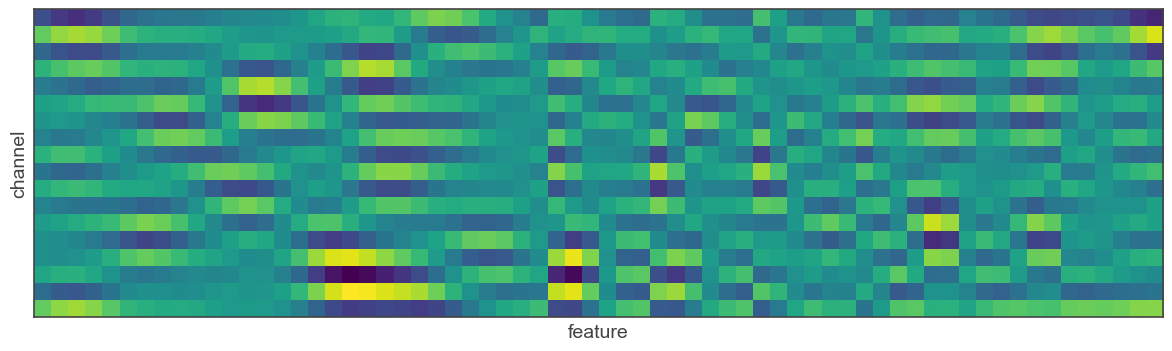

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(25, 4))
ax.imshow(full_delay_phase_results['pattern'])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('feature', fontsize=14)
ax.set_ylabel('channel', fontsize=14)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_phase_channel_pattern.png')
plt.savefig(plot_path, bbox_inches='tight')

In [70]:
delay_model = ForwardModel(**DEFAULT_FORWARD_MODEL_PARAMS['init'])
delay_sharpness = DEFAULT_FORWARD_MODEL_PARAMS['forward']['sharpness']

channel_weight_projection = delay_model.raw_ys_to_channel_weights(
    np.arange(180), delay_sharpness)
full_patterns = channel_weight_projection @ full_delay_phase_results['pattern'] 
pattern_mask = np.arange(9) * 20 + 10

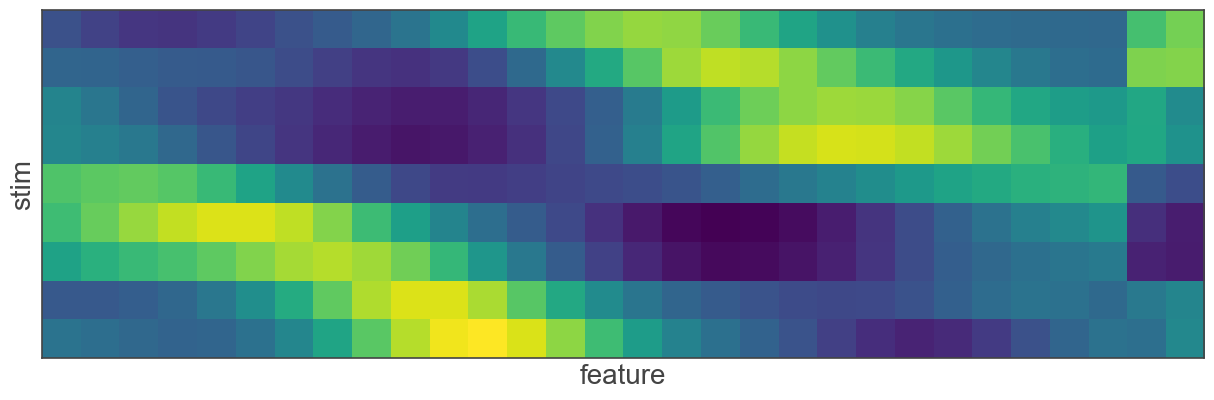

In [71]:
# display 1d patterns
fig, ax = plt.subplots(1, figsize=(15, 10))
selected_pattern = full_patterns[pattern_mask]
f_mask = DEFAULT_FEATURE_CONVERSION['1d']['old']
selected_pattern = selected_pattern[:, f_mask]
ax.imshow(selected_pattern, origin='lower')
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('stim', fontsize=20)
ax.set_xlabel('feature', fontsize=20)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_phase_pattern_1d.png')
plt.savefig(plot_path, bbox_inches='tight')

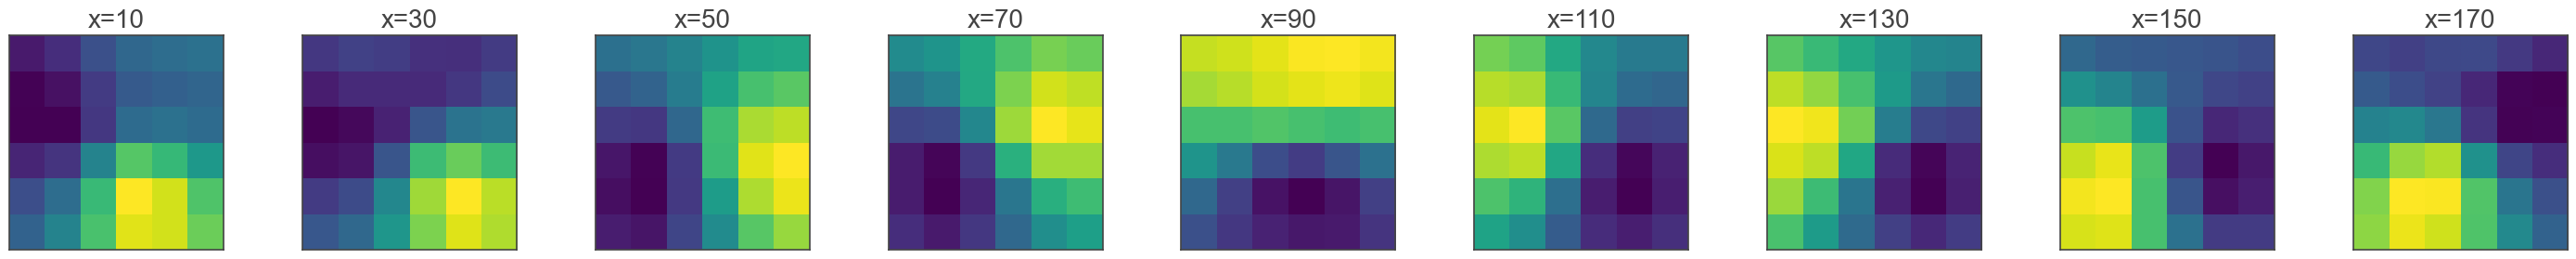

In [72]:
# display 2d patterns
fig, axs = plt.subplots(1, len(pattern_mask), figsize=(4*len(pattern_mask), 3))
selected_pattern = full_patterns[pattern_mask]
f_mask_start = int(len(DEFAULT_FEATURE_CONVERSION['1d']['old']) * DEFAULT_FEATURE_CONVERSION['1d']['zoom_ratio'])
f_mask_start = (f_mask_start + 2) if '0d' in DEFAULT_FEATURE_CONVERSION else f_mask_start
selected_pattern = selected_pattern[:, f_mask_start:]

for i in range(len(pattern_mask)):
    ax = axs[i]
    cond_pattern = selected_pattern[i]
    pattern_H = int(
        DEFAULT_FEATURE_CONVERSION['2d']['H'] * DEFAULT_FEATURE_CONVERSION['2d']['zoom_ratio'])
    pattern_W = int(
        DEFAULT_FEATURE_CONVERSION['2d']['W'] * DEFAULT_FEATURE_CONVERSION['2d']['zoom_ratio'])
    cond_pattern = cond_pattern.reshape(pattern_H, pattern_W)
    ax.imshow(cond_pattern, origin='lower')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'x={pattern_mask[i]}', fontsize=20)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_phase_pattern_2d.png')
plt.savefig(plot_path, bbox_inches='tight')

### center all encoded

#### convert channel weights to (distribution of) stimuli

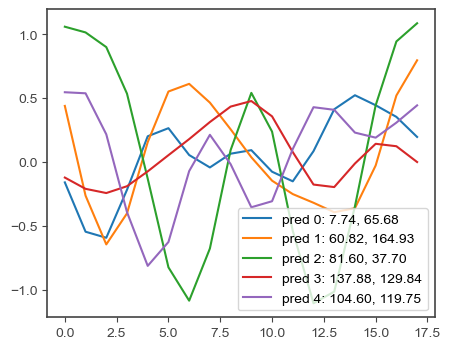

In [73]:
fig, ax = plt.subplots(1, figsize=(5, 4))
for i in range(5):
    y = full_delay_phase_results['test_ys'][i]
    l = full_delay_phase_results['preds'][i]
    ax.plot(l, label=f'pred {i}: {y[0]:.2f}, {y[1]:.2f}')
ax.legend()

In [74]:
DELAY_CHANNEL_PRED_MEAN = np.mean(full_delay_phase_results['preds'])
DELAY_CHANNEL_PRED_STD = np.std(full_delay_phase_results['preds'])
print(f'Delay channel prediction mean: {DELAY_CHANNEL_PRED_MEAN:.2f} std: {DELAY_CHANNEL_PRED_STD:.2f}')

Delay channel prediction mean: 0.06 std: 0.42


In [75]:
from utils.inverted_encoding import raw_channel_weights_to_pseudo_distrib

def channel_weights_to_pseudo_distrib(channel_weights, model, sharpness):
    return raw_channel_weights_to_pseudo_distrib(
       channel_weights, model, sharpness,
       delay_channel_pred_mean=DELAY_CHANNEL_PRED_MEAN,
       delay_channel_pred_std=DELAY_CHANNEL_PRED_STD
    )
    

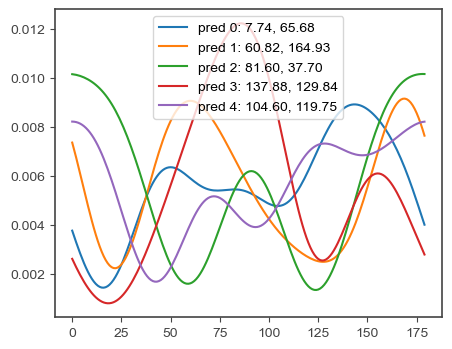

In [76]:
example_converted = channel_weights_to_pseudo_distrib(
    full_delay_phase_results['preds'], delay_model, 
    sharpness=30)
fig, ax = plt.subplots(1, figsize=(5, 4))
for i in range(5):
    y = full_delay_phase_results['test_ys'][i]
    l = example_converted[i]
    ax.plot(l, label=f'pred {i}: {y[0]:.2f}, {y[1]:.2f}')
ax.legend()

#### flip and adjust the distribution --> so it aligns with the target we are checking

In [77]:
from utils.inverted_encoding import shift_align_distrib

In [78]:
from utils.inverted_encoding import raw_display_shifted_distrib

def display_shifted_distrib(*args, **kwargs):
    if 'ylim_min' not in kwargs:
        kwargs['ylim_min'] = 0.0040
    if 'ylim_max' not in kwargs:
        kwargs['ylim_max'] = 0.0075
    return raw_display_shifted_distrib(*args, **kwargs)

#### Combine visualization

In [79]:
has_valid_prev_lmb = lambda df: ~(df['prev_last_response'].isna().values)
has_valid_prev_mask = has_valid_prev_lmb(full_delay_phase_results['test_df'])

In [80]:
from utils.inverted_encoding import raw_display_stats_and_distrib

def display_stats_and_distrib(
        ax, # set to None to disable visualization
        results, stats_type, 
        common_lmb=None, condition_lmbs={}, item_weights_lmb=None, 
        sharpness=delay_best_sharpness, # sharpness to convert to distrib
        return_subj_stats=False, # if to return each subject's stats
        
    ):
    return raw_display_stats_and_distrib(
        ax, results, stats_type, 
        common_lmb=common_lmb, condition_lmbs=condition_lmbs, 
        item_weights_lmb=item_weights_lmb,
        sharpness=sharpness, return_subj_stats=return_subj_stats,
        surrogate_model=delay_model,
        prediction_conversion_func=channel_weights_to_pseudo_distrib,
        display_shifted_distrib_func=display_shifted_distrib
    )


In [81]:
from utils.inverted_encoding import print_stats_results_as_tables

In [82]:
DEF_PLOT_W, DEF_PLOT_H = 6, 6

### Firstly, check the combined

In [83]:
stim1_valid_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_1_to_report'])).to_numpy()
stim2_valid_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_2_to_report'])).to_numpy()

--- accuracy ---
           mean    sem  t_stat  p_val
stim 1    0.697  0.083  8.3532    0.0
stim 2    0.504  0.081  6.1901    0.0
combined  0.608  0.072  8.4988    0.0
--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1   -0.008       0.091 -0.0911  0.9279
stim 2    0.062       0.061  1.0257  0.3121
combined  0.034       0.060  0.5665  0.5747


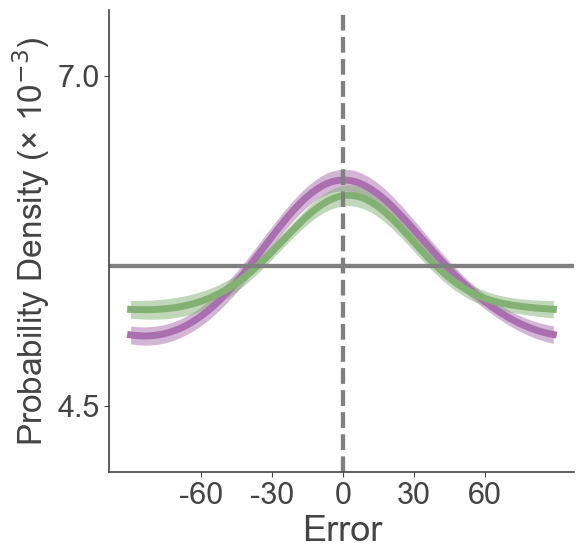

In [85]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
        'to_plot': False,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
# print(stats_results)
print_stats_results_as_tables(stats_results)
# ax.set_title('Errors: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')


In [86]:
both_has_prev_lmb = lambda df: (has_valid_prev_lmb(df) & valid_both_lmb(df))

--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1   -0.094       0.077 -1.2176  0.2315
stim 2    0.022       0.071  0.3095  0.7588
combined -0.032       0.048 -0.6661  0.5097


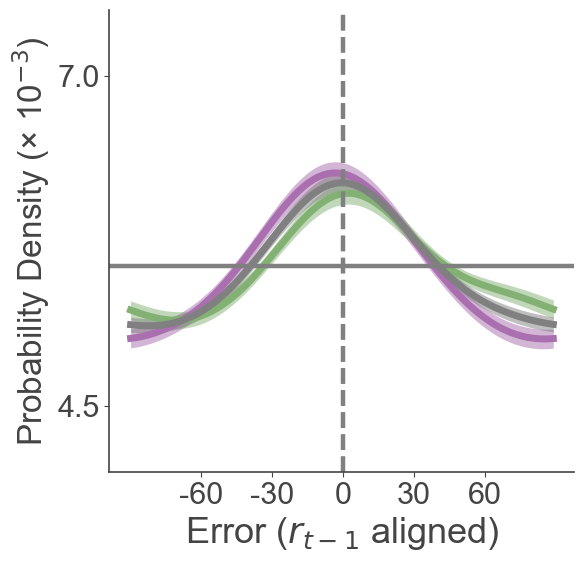

In [87]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=has_valid_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('SD: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_sd.png')
plt.savefig(plot_path, bbox_inches='tight')


--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1    0.145       0.081  1.7992  0.0806
stim 2    0.284       0.081  3.5259  0.0012
combined  0.191       0.062  3.0923  0.0039


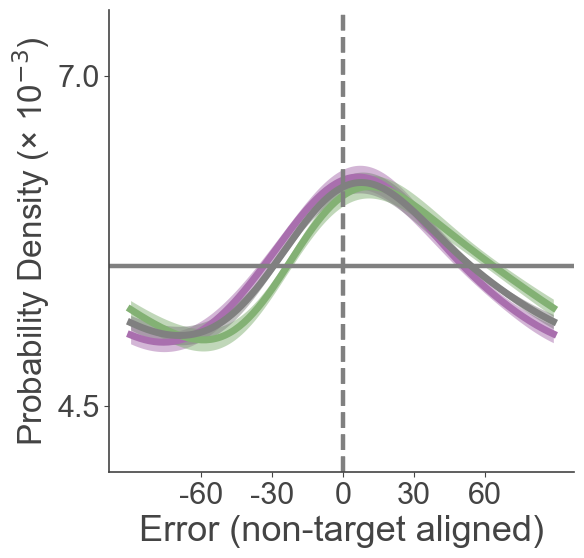

In [88]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sur', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('SUR: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_sur.png')
plt.savefig(plot_path, bbox_inches='tight')

#### certain v.s. uncertain?

--- accuracy ---
           mean    sem  t_stat  p_val
stim 1    0.704  0.099  7.1401    0.0
stim 2    0.451  0.084  5.3385    0.0
combined  0.591  0.076  7.7601    0.0
--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1   -0.033       0.113 -0.2964  0.7687
stim 2    0.085       0.072  1.1806  0.2457
combined  0.035       0.071  0.4999  0.6203


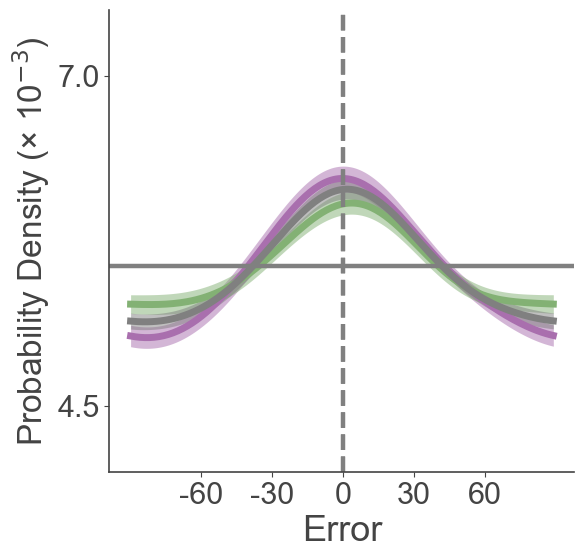

In [89]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))

certain_both_lmb = lambda df: ((df['trial_code'] == 0) | (df['stim_1_to_report'] & df['stim_2_to_report'])).values
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=certain_both_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)

print_stats_results_as_tables(stats_results)


--- accuracy ---
           mean    sem  t_stat  p_val
stim 1    0.712  0.091  7.8683    0.0
stim 2    0.460  0.087  5.2955    0.0
combined  0.587  0.078  7.5304    0.0
--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1   -0.022       0.099 -0.2237  0.8243
stim 2    0.060       0.066  0.8999  0.3743
combined  0.019       0.067  0.2826  0.7791


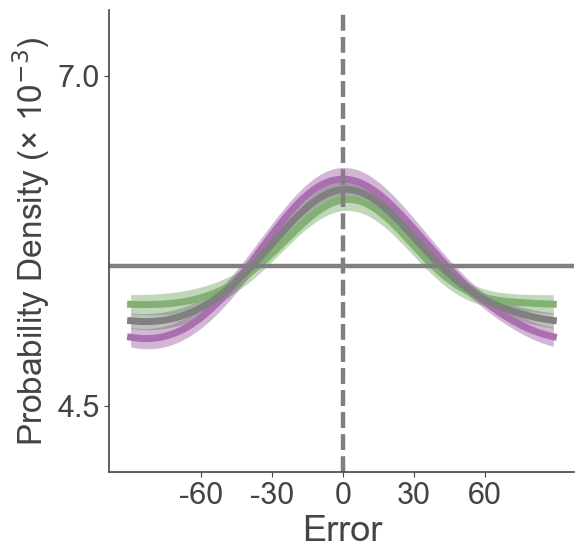

In [90]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))

uncertain_both_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_1_to_report'] & df['stim_2_to_report'])).values
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=uncertain_both_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)

print_stats_results_as_tables(stats_results)


**comment**: ok certainty does not matter

#### for comparison: check one item only decoding-encoding

In [91]:
stim1_only_lmb = lambda df: ((df['trial_code'] == 0) & (~(df['stim_2_to_report']))).to_numpy()
stim2_only_lmb = lambda df: ((df['trial_code'] == 0) & (~(df['stim_1_to_report']))).to_numpy()
valid_single_item_lmb = lambda df: (stim1_only_lmb(df) | stim2_only_lmb(df))

--- accuracy ---
           mean    sem  t_stat  p_val
stim 1    0.605  0.111  5.4512    0.0
stim 2    0.737  0.106  6.9440    0.0
combined  0.681  0.089  7.6166    0.0
--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1    0.069       0.105  0.6575  0.5151
stim 2    0.060       0.112  0.5342  0.5966
combined  0.081       0.074  1.0890  0.2836


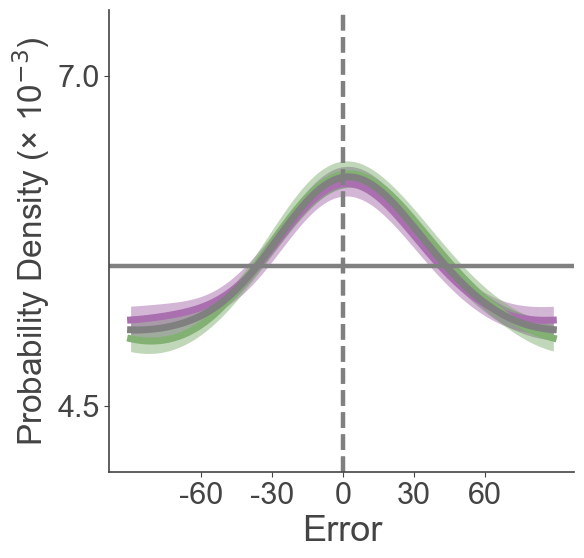

In [92]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=valid_single_item_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('Errors: full delay phase (1 item)', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, '1item_delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [93]:
single_has_prev_lmb = lambda df: (has_valid_prev_lmb(df) & valid_single_item_lmb(df))

--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1   -0.059       0.109 -0.5415  0.5916
stim 2    0.121       0.085  1.4239  0.1633
combined -0.008       0.058 -0.1356  0.8929


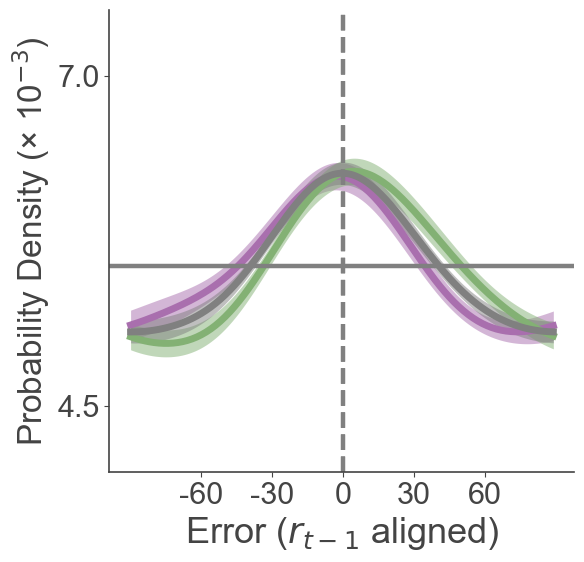

In [94]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=single_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('SD: full delay phase (1 item)', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, '1item_delay_decoded_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1   -0.028       0.082 -0.3451  0.7321
stim 2   -0.057       0.095 -0.6047  0.5493
combined -0.020       0.063 -0.3181  0.7523


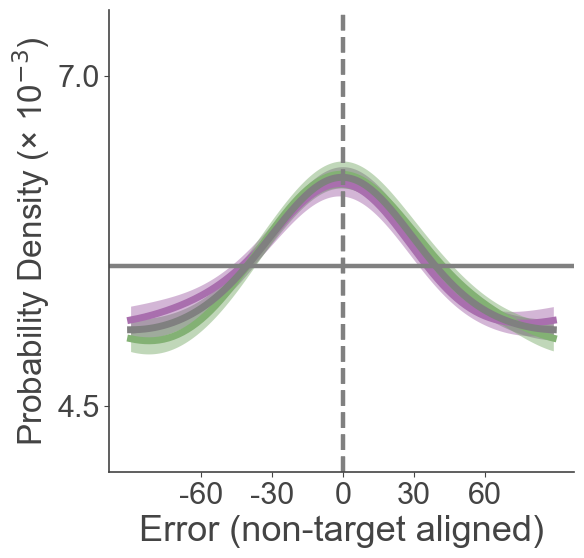

In [95]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sur', 
    common_lmb=valid_single_item_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('SUR: full delay phase (1 item)', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, '1item_delay_decoded_sur.png')
plt.savefig(plot_path, bbox_inches='tight')

#### group by serial difference

In [96]:
serial_diffs_s1_lmb = lambda df: np.abs(deg_signed_diff(
    df['prev_last_response'].values - df['stim_1'].values))
serial_diffs_s2_lmb = lambda df: np.abs(deg_signed_diff(
    df['prev_last_response'].values - df['stim_2'].values)) 

--- accuracy ---
         mean    sem  t_stat   p_val
stim 1  0.876  0.140  6.2361  0.0000
stim 2  0.426  0.137  3.1193  0.0036
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1  0.109       0.148  0.7378  0.4656
stim 2 -0.060       0.148 -0.4043  0.6885


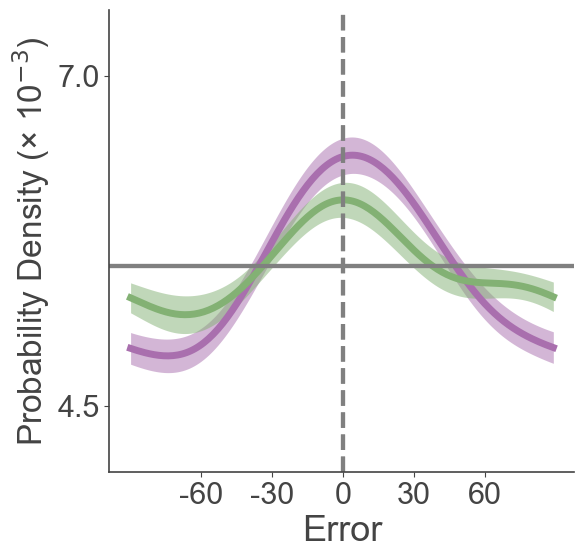

In [97]:
small_sd1_lmb = lambda d: (serial_diffs_s1_lmb(d) < 30)
small_sd2_lmb = lambda d: (serial_diffs_s2_lmb(d) < 30)

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': small_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': small_sd2_lmb,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('full delay phase error: small SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_small_sd_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1  0.074       0.145  0.5139  0.6105
stim 2  0.339       0.123  2.7570  0.0092


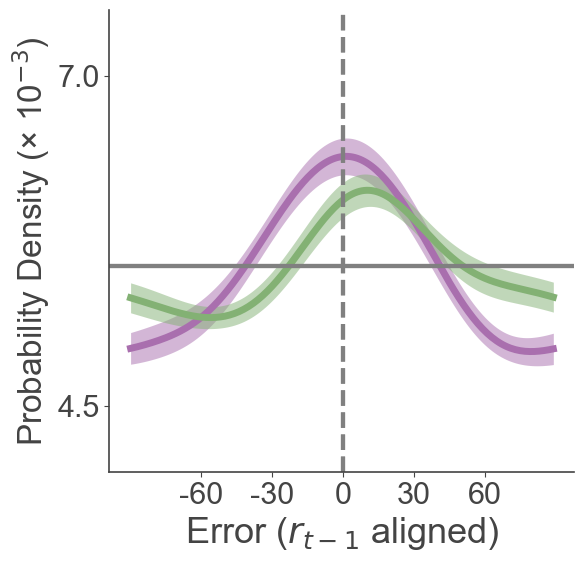

In [98]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': small_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': small_sd2_lmb,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('full delay phase sd bias: small SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_small_sd_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

--- accuracy ---
         mean    sem  t_stat  p_val
stim 1  0.788  0.129  6.0971    0.0
stim 2  0.659  0.105  6.2503    0.0
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1 -0.131       0.156 -0.8397  0.4068
stim 2  0.071       0.107  0.6639  0.5111


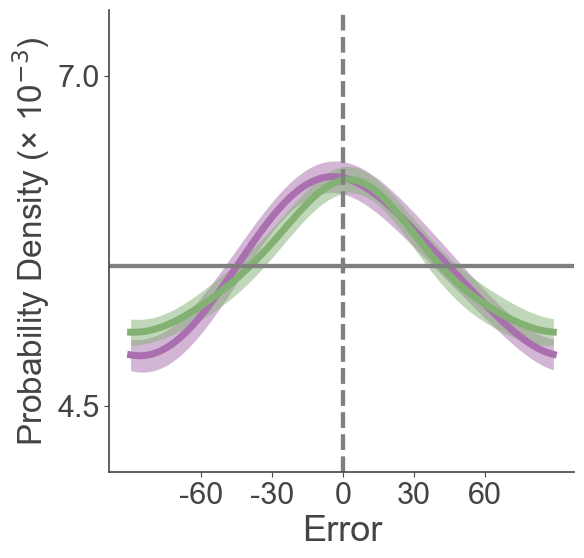

In [99]:
mid_sd1_lmb = lambda d: ((serial_diffs_s1_lmb(d) >= 30) & (serial_diffs_s1_lmb(d) < 60))
mid_sd2_lmb = lambda d: ((serial_diffs_s2_lmb(d) >= 30) & (serial_diffs_s2_lmb(d) < 60))

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': mid_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': mid_sd2_lmb,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('full delay phase error: medium SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_mid_sd_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1 -0.118       0.129 -0.9186  0.3646
stim 2 -0.129       0.132 -0.9726  0.3374


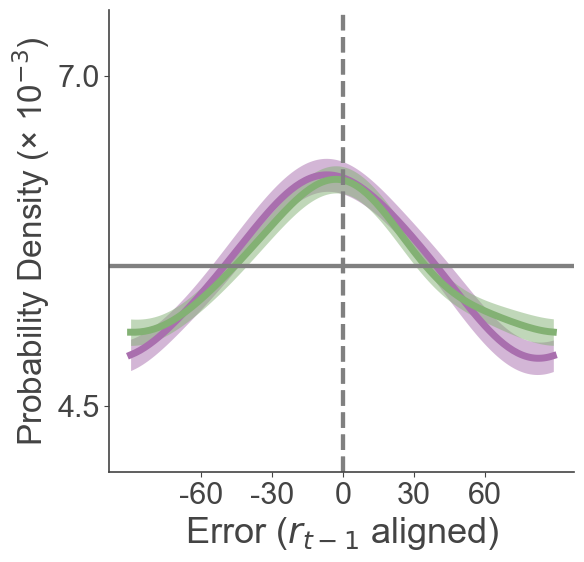

In [100]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': mid_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': mid_sd2_lmb,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('full delay phase sd bias: medium SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_mid_sd_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

--- accuracy ---
         mean    sem  t_stat   p_val
stim 1  0.547  0.133  4.1191  0.0002
stim 2  0.280  0.140  2.0085  0.0524
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1 -0.102       0.113 -0.9068  0.3707
stim 2  0.041       0.128  0.3236  0.7481


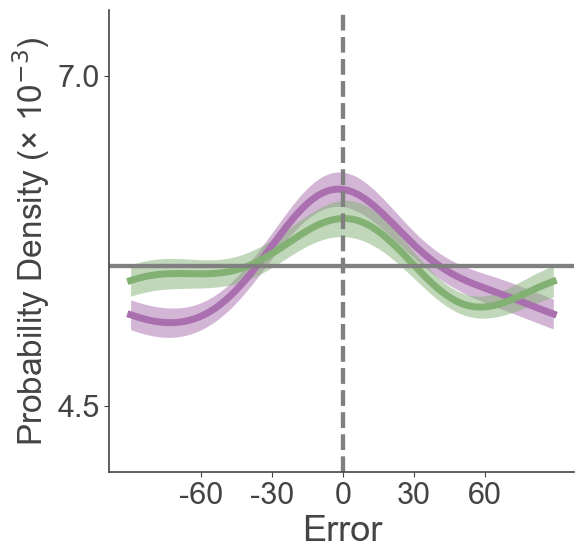

In [101]:
large_sd1_lmb = lambda d: (serial_diffs_s1_lmb(d) >= 60)
large_sd2_lmb = lambda d: (serial_diffs_s2_lmb(d) >= 60)

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': large_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': large_sd2_lmb,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('full delay phase error: large SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_large_sd_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

--- bias ---
        mean  sem (1e-3)  t_stat   p_val
stim 1 -0.26       0.140 -1.8606  0.0712
stim 2 -0.18       0.139 -1.3014  0.2016


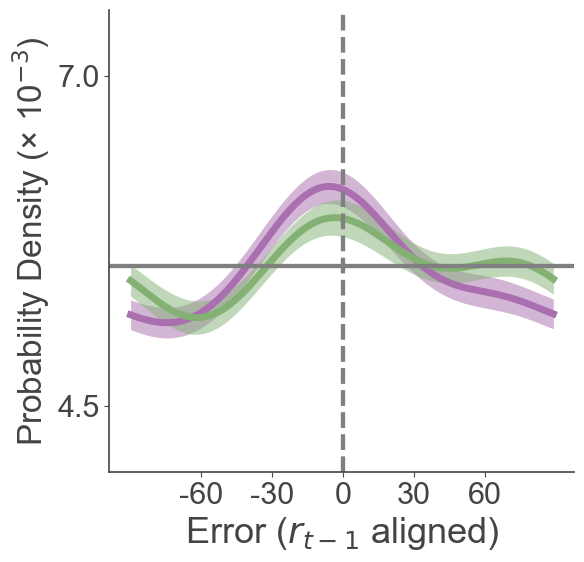

In [102]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': large_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': large_sd2_lmb,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('full delay phase sd bias: large SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_large_sd_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

#### Compare different modes?

In [103]:
MODE_COLOR_MAPPINGS = {
    'draw': 'skyblue',
    'click': 'coral',
}

In [104]:
from utils.inverted_encoding import stat_results_apply_ttest_2rel, display_ttest_rel2_results

accuracy: 202.0000 (p=0.0393)
bias: 324.0000 (p=0.8951)


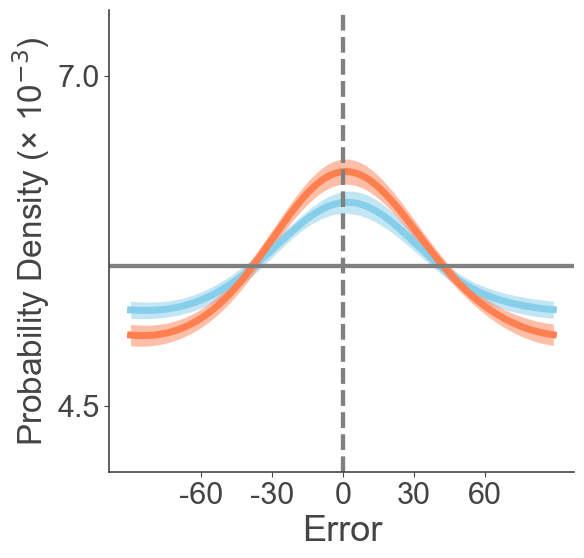

In [105]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
        'plot_settings': {
            'plot_line_color': MODE_COLOR_MAPPINGS['draw'],
            'plot_line_style': '-',
            'plot_line_alpha': 1,
        },
    },
    'wheel': {
        'target': 'combined',
        'lmb': click_lmb,
        'plot_settings': {
            'plot_line_color': MODE_COLOR_MAPPINGS['click'],
            'plot_line_style': '-',
            'plot_line_alpha': 1,
        },
    },
}

_, stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb,
    return_subj_stats=True)

# stats results: subject stats -- 2 
display_ttest_rel2_results(stats_results, ['draw', 'wheel'])
# ax.set_title('full delay phase error: draw&click', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_modes_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

bias: 323.0000 (p=0.8828)


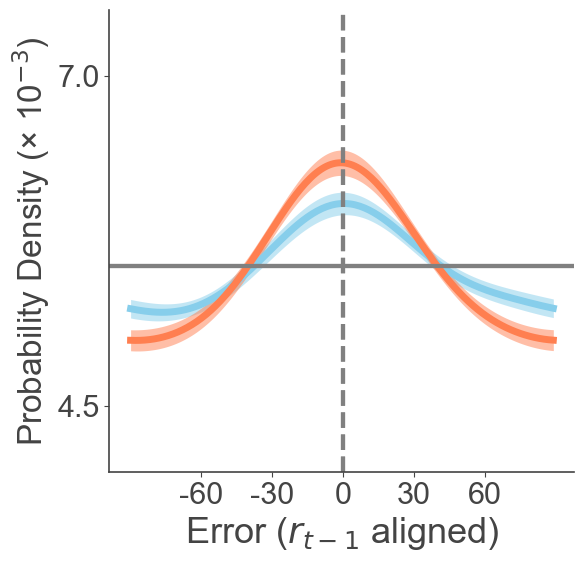

In [106]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
        'plot_settings': {
            'plot_line_color': MODE_COLOR_MAPPINGS['draw'],
            'plot_line_style': '-',
            'plot_line_alpha': 1,
        },
    },
    'click': {
        'target': 'combined',
        'lmb': click_lmb,
        'plot_settings': {
            'plot_line_color': MODE_COLOR_MAPPINGS['click'],
            'plot_line_style': '-',
            'plot_line_alpha': 1,
        },
    },
}
_, stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=has_valid_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb,
    return_subj_stats=True)
display_ttest_rel2_results(stats_results, ['draw', 'click'])
# ax.set_title('full delay phase sd bias: draw&click', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_modes_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

bias: 196.0000 (p=0.0308)


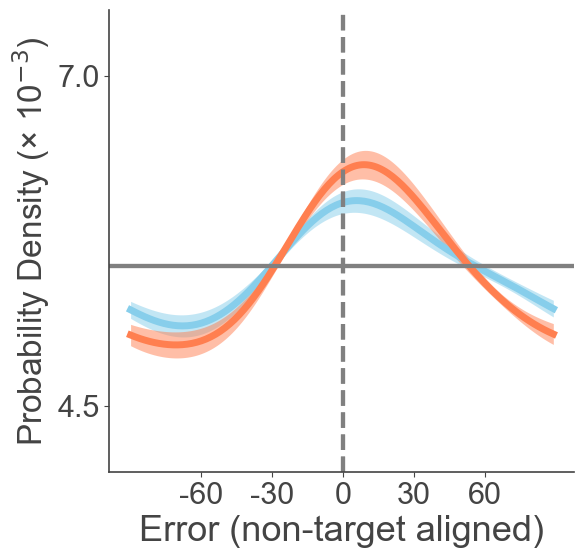

In [107]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
        'plot_settings': {
            'plot_line_color': MODE_COLOR_MAPPINGS['draw'],
            'plot_line_style': '-',
            'plot_line_alpha': 1,
        },
    },
    'click': {
        'target': 'combined',
        'lmb': click_lmb,
        'plot_settings': {
            'plot_line_color': MODE_COLOR_MAPPINGS['click'],
            'plot_line_style': '-',
            'plot_line_alpha': 1,
        },
    },
}
_, stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sur', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb,
    return_subj_stats=True)
display_ttest_rel2_results(stats_results, ['draw', 'click'])
# ax.set_title('full delay phase sur bias: draw&click', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_modes_sur.png')
plt.savefig(plot_path, bbox_inches='tight')

##### Comments:
- Decoding accuracy is impacted by both (1) sequential order of presentation and (2) the feature distance between current and previous item. This speaks to RSA results, serves as another indirect evidence that perceptual history serves to 'stabilize' the system
- But why we do not see significant bias overall? Here we have concatenated data across the whole 5 seconds delay; following analysis will show the direction of bias change over time...

### Train & test across modes

In [108]:
draw_delay_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_delay_lmb = lambda df: (df['mode'] == 'click').to_numpy()
mode_lmbs = {
    'draw': draw_delay_lmb,
    'click': click_delay_lmb,
}

In [109]:
all_delay_across_modes = {}
item_weights_lmb = lambda df: convert_df_to_delay_design_matrix(df)
for train_mode in ['draw', 'click']:
    for test_mode in ['draw', 'click']:
        print(f'Trained on {train_mode}, tested on {test_mode}')
        n_subjects = len(all_subjs)
        train_lmb = mode_lmbs[train_mode]
        test_lmb = mode_lmbs[test_mode]
        modes_delay_phase_results = cv_train_test_invert_encoding(
            DEFAULT_FORWARD_MODEL_PARAMS, 
            delay_phase, delay_phase, 
            ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
            train_lmb, test_lmb, 
            item_weights_lmb, n_subjects)
        all_delay_across_modes[(train_mode, test_mode)] = modes_delay_phase_results

Trained on draw, tested on draw
Trained on draw, tested on click
Trained on click, tested on draw
Trained on click, tested on click


In [110]:
mode_prev_lmbs = {
    'draw': lambda df: draw_lmb(df) & has_valid_prev_lmb(df),
    'click': lambda df: click_lmb(df) & has_valid_prev_lmb(df),
}

#### For simplicity: combining N=1 and N=2

In [111]:
def keep_share_axis_only(axs):
    nr,nc = axs.shape
    for i in range(nr):
        for j in range(nc):
            if i != nr-1:
                axs[i,j].set_xticks([])
                axs[i,j].set_xlabel('')
            if j != 0:
                axs[i,j].set_yticks([])
                axs[i,j].set_ylabel('')


draw -> draw
draw -> click
click -> draw
click -> click


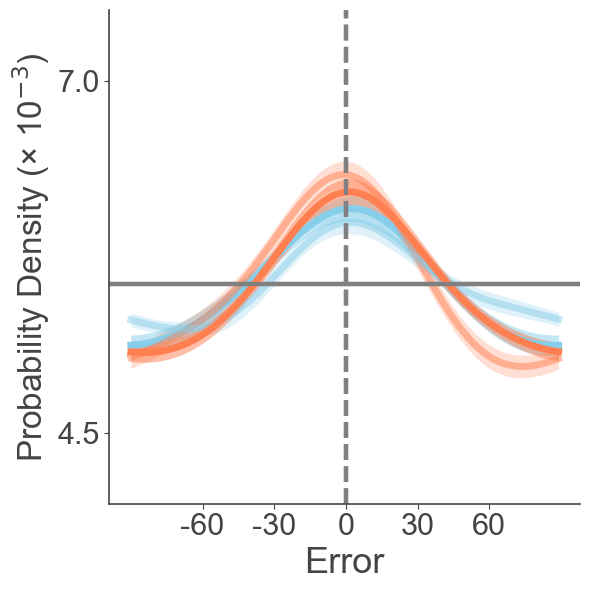

In [112]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
across_modes_acc_stats = {}
for i, train_mode in enumerate(['draw', 'click']):
    for j, test_mode in enumerate(['draw', 'click']):
        print(f'{train_mode} -> {test_mode}')
        results = all_delay_across_modes[(train_mode, test_mode)]
        test_lmb = mode_lmbs[test_mode]

        # specific plot settings
        mode_cond_name = f'{train_mode}->{test_mode}'
        plot_alpha = 1 if test_mode == train_mode else 0.5
        plot_settings = {
            mode_cond_name: {
                'target': 'combined',
                'lmb': None,
                'plot_settings': {
                    'plot_line_color': MODE_COLOR_MAPPINGS[test_mode],
                    'plot_line_style': '-',
                    'plot_line_alpha': plot_alpha,
                },
            },
        }

        _, stats_results = display_stats_and_distrib(ax,
            results,
            stats_type='accuracy', 
            common_lmb=test_lmb, condition_lmbs=plot_settings,
            item_weights_lmb=item_weights_lmb,
            return_subj_stats=True)
        stats_results = stats_results[mode_cond_name]
        across_modes_acc_stats[f'{train_mode}->{test_mode}'] = stats_results

plt.tight_layout()
plot_path = os.path.join(PLOTS_FOLDER, 'single_or_both_delay_decoded_cross_modes_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [113]:
from utils.inverted_encoding import anova_within_subject_test

In [114]:
_ = anova_within_subject_test(across_modes_acc_stats, 'accuracy')

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
condition  4.4624 3.0000 105.0000 0.0054

                    comparison  t_stat   p_val
0    draw->draw vs draw->click   243.0  0.1615
1    draw->draw vs click->draw   233.0  0.1189
2   draw->draw vs click->click   291.0  0.5189
3   draw->click vs click->draw   157.0  0.0049
4  draw->click vs click->click   295.0  0.5601
5  click->draw vs click->click   183.0  0.0175


draw -> draw
draw -> click
click -> draw
click -> click


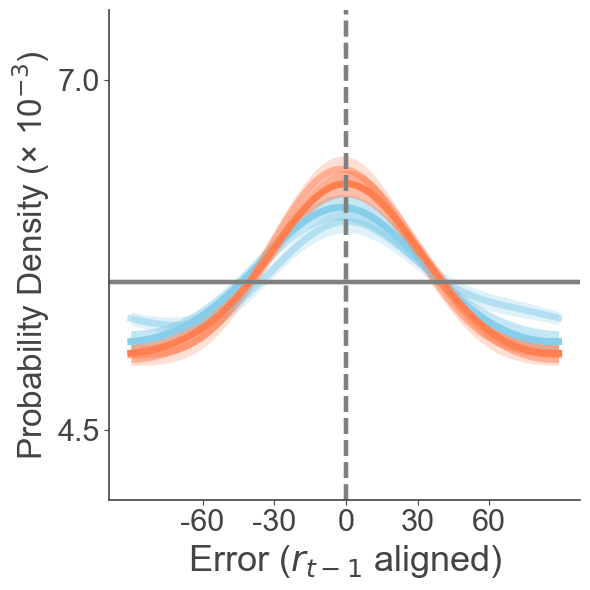

In [115]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
across_modes_sd_stats = {}
for i, train_mode in enumerate(['draw', 'click']):
    for j, test_mode in enumerate(['draw', 'click']):
        print(f'{train_mode} -> {test_mode}')
        results = all_delay_across_modes[(train_mode, test_mode)]
        test_lmb = mode_prev_lmbs[test_mode]

        # specific plot settings
        mode_cond_name = f'{train_mode}->{test_mode}'
        plot_alpha = 1 if test_mode == train_mode else 0.5
        plot_settings = {
            mode_cond_name: {
                'target': 'combined',
                'lmb': None,
                'plot_settings': {
                    'plot_line_color': MODE_COLOR_MAPPINGS[test_mode],
                    'plot_line_style': '-',
                    'plot_line_alpha': plot_alpha,
                },
            },
        }

        _, stats_results = display_stats_and_distrib(ax,
            results,
            stats_type='sd', 
            common_lmb=test_lmb, condition_lmbs=plot_settings,
            item_weights_lmb=item_weights_lmb,
            return_subj_stats=True)
        stats_results = stats_results[mode_cond_name]
        across_modes_sd_stats[f'{train_mode}->{test_mode}'] = stats_results

plt.tight_layout()
plot_path = os.path.join(PLOTS_FOLDER, 'single_or_both_delay_decoded_cross_modes_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

In [116]:
_ = anova_within_subject_test(across_modes_sd_stats, 'bias')

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
condition  0.4103 3.0000 105.0000 0.7459

                    comparison  t_stat   p_val
0    draw->draw vs draw->click   295.0  0.5601
1    draw->draw vs click->draw   331.0  0.9814
2   draw->draw vs click->click   285.0  0.4601
3   draw->click vs click->draw   285.0  0.4601
4  draw->click vs click->click   258.0  0.2451
5  click->draw vs click->click   317.0  0.8099


#### Store subject accuracy

In [117]:
def store_subject_stats(results, common_lmb, condition_lmbs, stats_type, cond_name,
        item_weights_lmb=item_weights_lmb, sharpness=delay_best_sharpness):
    # collect subject level stats
    stats_results = display_stats_and_distrib(
        ax=None,
        results=results, 
        stats_type=stats_type, 
        common_lmb=common_lmb, 
        condition_lmbs=condition_lmbs, 
        item_weights_lmb=item_weights_lmb, 
        sharpness=sharpness,
        return_subj_stats=True # need subject wise stats
    )
    stats_results = stats_results[1] # fetch only subject level stats

    # store it
    sub_result_folder = os.path.join(PROCESSED_FOLDER, f'{cond_name}')
    os.makedirs(sub_result_folder, exist_ok=True)
    result_path = os.path.join(sub_result_folder, f'{stats_type}.json')
    with open(result_path, 'w') as f: 
        json.dump(stats_results, f, indent=4)

##### store subject accuracy during drawing v.s. clicking tasks

In [118]:
for mode in ['draw', 'click']:
    test_lmb = mode_lmbs[mode]
    stat_extract_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': stim1_valid_lmb,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': stim2_valid_lmb,
        },
        'combined': {
            'target': 'combined',
            'lmb': None,
        },
    }
    for stats_type in ['accuracy', 'sd', 'sur']:
        print(f'Saving {mode} {stats_type} stats')
        common_lmb = test_lmb
        if stats_type == 'sd':
            common_lmb = mode_prev_lmbs[mode]
        store_subject_stats(
            all_delay_across_modes[(mode, mode)], 
            common_lmb, 
            stat_extract_settings, 
            stats_type, 
            f'whole_delay_{mode}2{mode}',
            item_weights_lmb=item_weights_lmb,
            sharpness=delay_best_sharpness)
    

Saving draw accuracy stats
Saving draw sd stats
Saving draw sur stats
Saving click accuracy stats
Saving click sd stats
Saving click sur stats


##### (Exp): can we see cardinal / oblique bias in prediction?

In [119]:
def get_stim_restrict_bias(results, common_lmb, center_sample, window_size,
        item_weights_lmb=item_weights_lmb, to_fetch='combined', sharpness=delay_best_sharpness):
    stim1_within_range_lmb = lambda df: (
        stim1_valid_lmb(df) &
        (np.abs(deg_signed_diff(df['stim_1'].values -center_sample)) <= window_size))
    stim2_within_range_lmb = lambda df: (
        stim2_valid_lmb(df) &
        (np.abs(deg_signed_diff(df['stim_2'].values - center_sample)) <= window_size))
    at_least_one_within_lmb = lambda df: (
        stim1_within_range_lmb(df) | stim2_within_range_lmb(df))

    plot_settings = {
        'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_within_range_lmb,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': stim2_within_range_lmb,
        },
        'combined': {
            'target': 'combined',
            'lmb': at_least_one_within_lmb,
        },
    }
        
    stats = display_stats_and_distrib(
        ax=None, results=results, stats_type='accuracy', 
        common_lmb=common_lmb, condition_lmbs=plot_settings, 
        item_weights_lmb=item_weights_lmb,
        sharpness=sharpness)   

    # only fetch the acc and bias from the combined
    stats = stats[to_fetch]
    return stats

In [120]:
def display_acc_bias_as_tuning(results, common_lmb, condition_name,
        item_weights_lmb=item_weights_lmb,
        to_fetch='combined', sharpness=delay_best_sharpness):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sample_step = 15
    sample_xs = np.arange(int(180/sample_step)) * sample_step
    collected_sample_stats = []
    for sample_x in sample_xs:
        stats = get_stim_restrict_bias(
            results,
            common_lmb=common_lmb,
            center_sample=sample_x,
            window_size=sample_step,
            item_weights_lmb=item_weights_lmb,
            to_fetch=to_fetch,
            sharpness=sharpness
        )
        collected_sample_stats.append(stats)

    # make it wrap around
    sample_xs = np.append(sample_xs, 180)
    collected_sample_stats.append(collected_sample_stats[0])
        
    for i, stat_name in enumerate(['accuracy', 'bias']):
        stats_mean = np.array([
            collected_sample_stats[i][stat_name]['mean'] for i in range(len(sample_xs))])
        stats_sem = np.array([
            collected_sample_stats[i][stat_name]['sem'] for i in range(len(sample_xs))])
        axs[i].errorbar(sample_xs, stats_mean, yerr=stats_sem, fmt='o', capsize=5)

        axs[i].set_xlabel('Stim Degree')
        axs[i].axvline(45, color='gray', linestyle='--', alpha=0.5)
        axs[i].axvline(90, color='gray', linestyle='--')
        axs[i].axvline(135, color='gray', linestyle='--', alpha=0.5)
        axs[i].axhline(0, color='red', linestyle='--')

        axs[i].set_xticks(sample_xs)

    axs[0].set_ylim([-1.0, 2.0])
    axs[0].set_yticks(np.arange(-0.5, 2.0, 0.5))
    axs[0].set_ylabel('evidence', fontsize=14)
    axs[1].set_ylim([-0.1, 0.1])
    axs[1].set_yticks(np.arange(-0.08, 0.1, 0.02))
    axs[1].set_ylabel('bias', fontsize=14)

    # save the figure
    plot_path = os.path.join(PLOTS_FOLDER, f'{condition_name}_decoded_tuning_func.png')
    plt.savefig(plot_path, bbox_inches='tight')



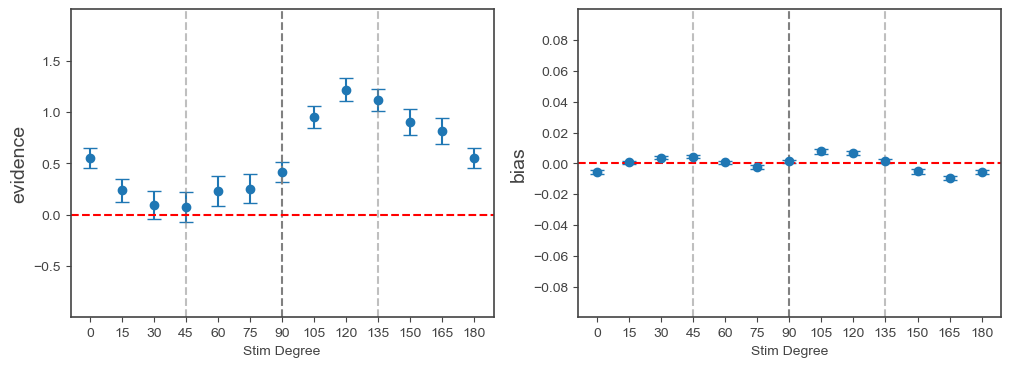

In [121]:
default_lmb = lambda df: np.ones(len(df), dtype=bool)
display_acc_bias_as_tuning(
    results=full_delay_phase_results,
    common_lmb=default_lmb, condition_name='all_delay')

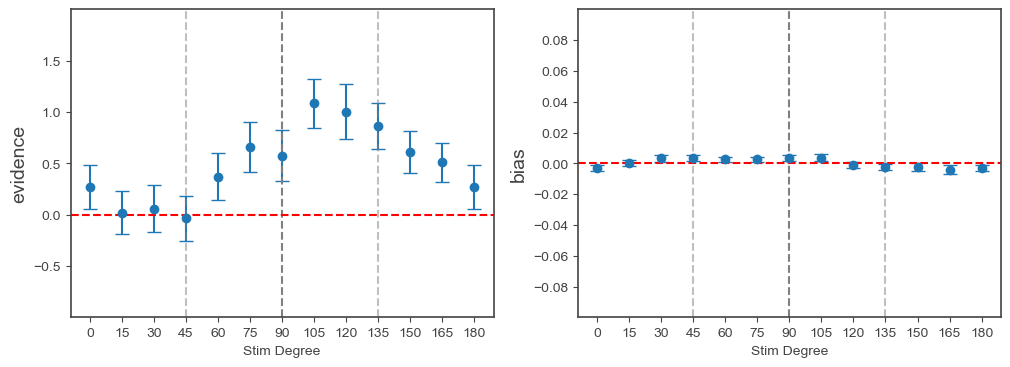

In [122]:
display_acc_bias_as_tuning(
    results=all_delay_across_modes[('draw', 'draw')],
    common_lmb=draw_lmb, condition_name='draw_delay')

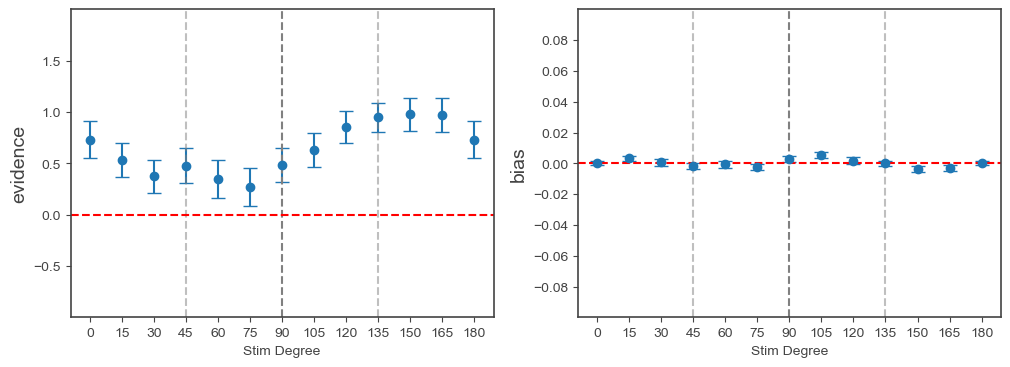

In [123]:
display_acc_bias_as_tuning(
    results=all_delay_across_modes[('click', 'click')],
    common_lmb=click_lmb, condition_name='click_delay')

##### What about ISI

In [124]:
from copy import deepcopy

DEFAULT_ISI_FORWARD_MODEL_PARAMS = deepcopy(DEFAULT_FORWARD_MODEL_PARAMS)
DEFAULT_ISI_FORWARD_MODEL_PARAMS['forward']['sharpness'] = ISI_best_sharpness


In [125]:
valid_isi_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_1_to_report'])).to_numpy()
isi_item_weights_lmb = lambda df: np.array([
    np.ones(len(df)),
    np.zeros(len(df)),
]).T
isi_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    ISI_phase, ISI_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
        mean    sem  t_stat   p_val
stim 1  1.09  0.157  6.9565  0.0000
stim 2  0.07  0.072  0.9724  0.3375
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1  0.026       0.103  0.2511  0.8032
stim 2 -0.018       0.064 -0.2820  0.7796


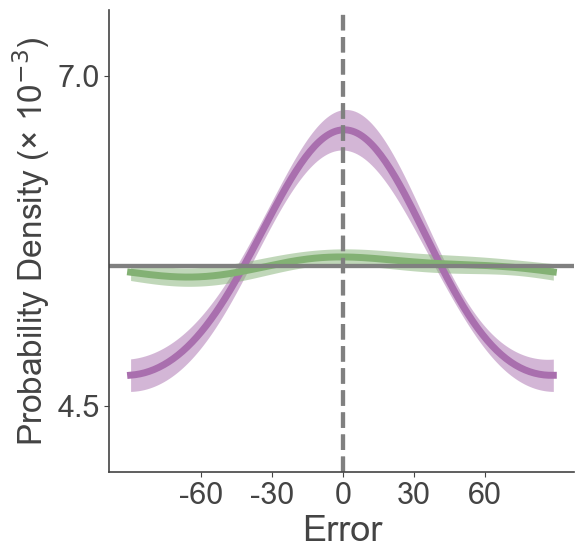

In [126]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    isi_decode_results,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)

print_stats_results_as_tables(stats_results)
plot_path = os.path.join(PLOTS_FOLDER, 'isi_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

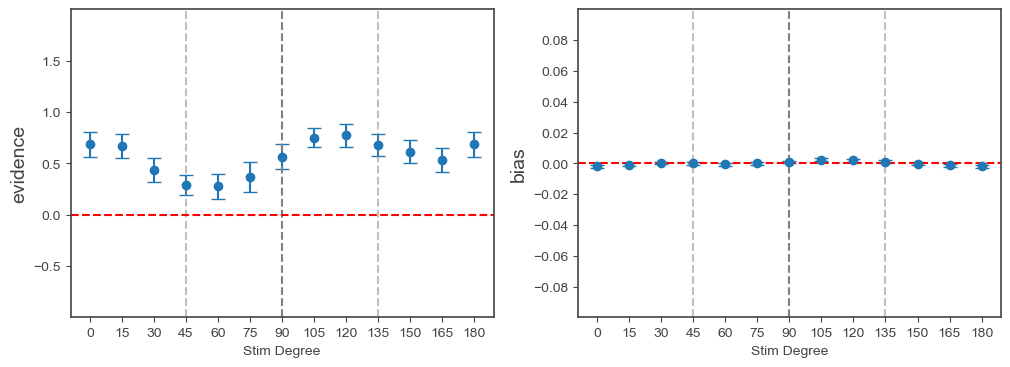

In [127]:
display_acc_bias_as_tuning(
    results=isi_decode_results,
    common_lmb=valid_isi_lmb, condition_name='isi',
    item_weights_lmb=isi_item_weights_lmb,
    to_fetch='stim 1',
    sharpness=ISI_best_sharpness)

#### And post-encoding phases

In [128]:
post_enc1_phase = np.arange(start=1750//50, stop=2250//50).astype(int)
post_enc2_phase = np.arange(start=4000//50, stop=4500//50).astype(int)

In [129]:
post_enc1_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    post_enc1_phase, post_enc1_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat   p_val
stim 1  1.434  0.193  7.4280  0.0000
stim 2  0.066  0.073  0.8997  0.3744
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1  0.070       0.128  0.5446  0.5895
stim 2  0.109       0.065  1.6684  0.1042


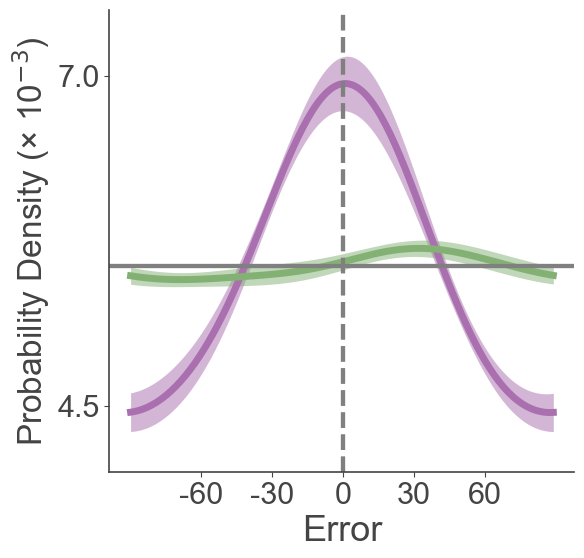

In [130]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    post_enc1_decode_results,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)

print_stats_results_as_tables(stats_results)
plot_path = os.path.join(PLOTS_FOLDER, 'post_enc1_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')


In [131]:
post_enc2_decode_results = cv_train_test_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    post_enc2_phase, post_enc2_phase, 
    ['stim_1', 'stim_2' ], ['stim_1', 'stim_2'], 
    None, None,
    item_weights_lmb, n_subjects)

--- accuracy ---
           mean    sem  t_stat  p_val
stim 1    0.387  0.075  5.1468    0.0
stim 2    0.730  0.115  6.3649    0.0
combined  0.561  0.078  7.1532    0.0
--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1   -0.068       0.070 -0.9685  0.3394
stim 2    0.096       0.094  1.0207  0.3144
combined  0.026       0.068  0.3796  0.7065


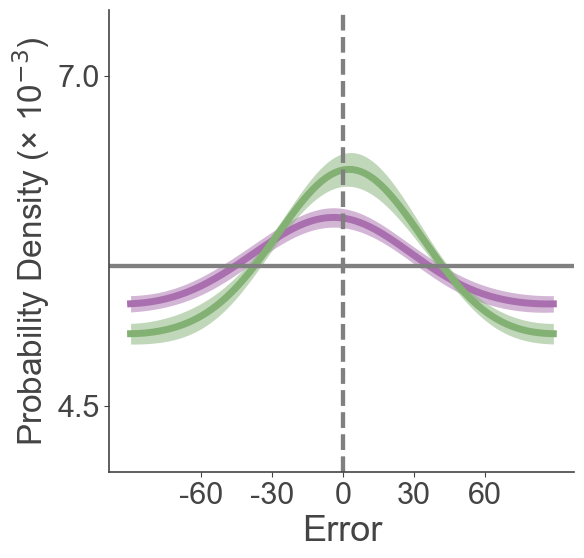

In [132]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
        'to_plot': False,
    },
}
stats_results = display_stats_and_distrib(ax,
    post_enc2_decode_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
# print(stats_results)
print_stats_results_as_tables(stats_results)
# ax.set_title('Errors: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'post_enc2_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')


##### Also store the combined ISI v.s. Full-delay results

In [133]:
## isi
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'draw': {
        'target': 'stim 1',
        'lmb': draw_lmb,
    },
    'click': {
        'target': 'stim 1',
        'lmb': click_lmb,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = valid_isi_lmb
    if stats_type == 'sd':
        common_lmb = lambda d: valid_isi_lmb(d) & has_valid_prev_lmb(d)
    store_subject_stats(
        isi_decode_results, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'whole_isi_combined',
        item_weights_lmb=isi_item_weights_lmb,
        sharpness=ISI_best_sharpness)
    

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


In [134]:
## delay
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
    },
    'click': {
        'target': 'combined',
        'lmb': click_lmb,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {stats_type} stats')
    common_lmb = None
    if stats_type == 'sd':
        common_lmb = has_valid_prev_lmb
    store_subject_stats(
        full_delay_phase_results, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'whole_delay_combined',
        item_weights_lmb=item_weights_lmb,
        sharpness=delay_best_sharpness)
    

Saving accuracy stats
Saving sd stats
Saving sur stats


#### We also want to separate the stim that are easy or hard

In [135]:
VERTICAL_LMB = lambda d: (np.abs(deg_signed_diff(d-0)) <= 15)
HORIZONTAL_LMB = lambda d: (np.abs(deg_signed_diff(d-90)) <= 15)
UPPER_DIAG_LMB = lambda d: (np.abs(deg_signed_diff(d-45)) <= 15)
LOWER_DIAG_LMB = lambda d: (np.abs(deg_signed_diff(d-135)) <= 15)
UPPER_LMB = lambda d: (d < 90)
LOWER_LMB = lambda d: (d > 90)

angle_range_lmbs = {
    'diag': lambda d: ((UPPER_DIAG_LMB(d) | LOWER_DIAG_LMB(d))),
    'cardinal': lambda d: ((VERTICAL_LMB(d) | HORIZONTAL_LMB(d))),
    'upper': lambda d: UPPER_LMB(d),
    'lower': lambda d: LOWER_LMB(d),
    'vertical': lambda d: VERTICAL_LMB(d),
    'horizontal': lambda d: HORIZONTAL_LMB(d),
    'other': lambda d: (~((UPPER_DIAG_LMB(d)) | (LOWER_DIAG_LMB(d)) | (VERTICAL_LMB(d)) | (HORIZONTAL_LMB(d)))),
}

In [136]:
## delay
angle_stats_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

angle_stats_folder = os.path.join(PROCESSED_FOLDER, 'whole_delay_angles')
os.makedirs(angle_stats_folder, exist_ok=True)
for stats_type in ['accuracy', 'sd', 'sur']:
    # for each stats
    print(f'Saving {stats_type} stats')
    angle_stats_combined = {}
    for angle_name, angle_lmb in angle_range_lmbs.items():
        angle_stim1_lmb = lambda df: (stim1_valid_lmb(df) & angle_lmb(df['stim_1'].values))
        angle_stim2_lmb = lambda df: (stim2_valid_lmb(df) & angle_lmb(df['stim_2'].values))
        angle_valid_lmb = lambda df: (angle_stim1_lmb(df) | angle_stim2_lmb(df))
        angle_stats_extract_settings = {
            'stim 1': {
                'target': 'stim 1',
                'lmb': angle_stim1_lmb,
            },
            'stim 2': {
                'target': 'stim 2',
                'lmb': angle_stim2_lmb,
            },
            'combined': {
                'target': 'combined',
                'lmb': angle_valid_lmb,
            },
        }

        common_lmb = None
        if stats_type == 'sd':
            common_lmb = has_valid_prev_lmb

        # extract stats
        _, stats_results = display_stats_and_distrib(
            ax=None,
            results=full_delay_phase_results, 
            stats_type=stats_type, 
            common_lmb=common_lmb, 
            condition_lmbs=angle_stats_extract_settings, 
            item_weights_lmb=item_weights_lmb, 
            sharpness=delay_best_sharpness,
            return_subj_stats=True # need subject wise stats
        )

        # take only the one we are interested in
        angle_stats_combined[angle_name] = stats_results['combined']

    result_path = os.path.join(angle_stats_folder, f'{stats_type}.json')
    with open(result_path, 'w') as f: 
        json.dump(angle_stats_combined, f, indent=4)


Saving accuracy stats
Saving sd stats
Saving sur stats


### Finally, how well could ISI pattern generalized to the delay pattern?

In [137]:
isi_delay_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    ISI_phase, delay_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, None,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
           mean    sem  t_stat  p_val
stim 1    1.023  0.107  9.5647    0.0
stim 2    0.701  0.129  5.4506    0.0
combined  0.870  0.095  9.1975    0.0
--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1    0.082       0.094  0.8759  0.3870
stim 2    0.138       0.076  1.8176  0.0777
combined  0.103       0.062  1.6548  0.1069


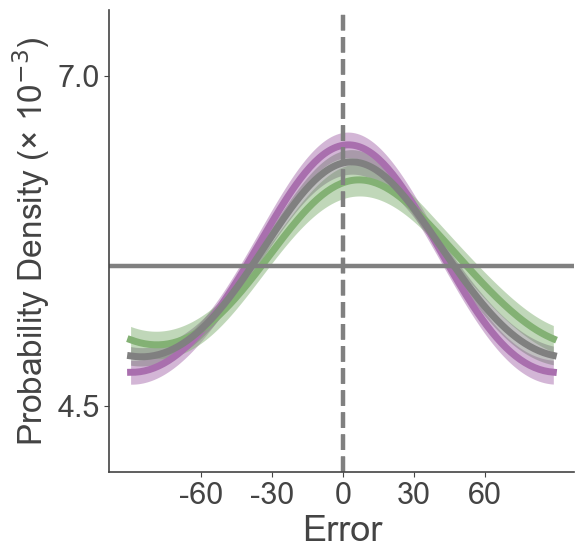

In [138]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

stats_results=display_stats_and_distrib(ax,
    isi_delay_decode_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb, # assuming taking all?
    sharpness=delay_best_sharpness
)
print_stats_results_as_tables(stats_results)
plot_path = os.path.join(PLOTS_FOLDER, 'isi_delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [139]:
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = None
    if stats_type == 'sd':
        common_lmb = has_valid_prev_lmb
    store_subject_stats(
        isi_delay_decode_results, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'isi_delay_combined',
        item_weights_lmb=item_weights_lmb,
        sharpness=delay_best_sharpness)

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


#### Exploration: is it possible to decode the pattern from encoding phase gaze?

In [140]:
enc1_phase = np.arange(start=1000//50, stop=1750//50).astype(int)

In [141]:
enc1_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase, enc1_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat   p_val
stim 1  0.582  0.116  5.0164  0.0000
stim 2 -0.008  0.066 -0.1287  0.8983
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1 -0.012       0.071 -0.1646  0.8702
stim 2  0.130       0.057  2.2725  0.0293


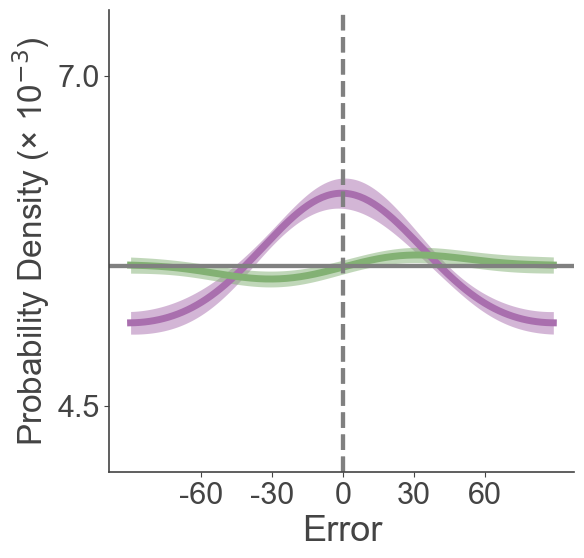

In [142]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results=display_stats_and_distrib(ax,
    enc1_decode_results,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'enc1_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

##### further split the phase into before and after cue onset

In [143]:
enc1_phase_before_cue = np.arange(start=1000//50, stop=1250//50).astype(int)
enc1_phase_during_cue = np.arange(start=1250//50, stop=1500//50).astype(int)
enc1_phase_after_cue = np.arange(start=1500//50, stop=1750//50).astype(int)

In [144]:
enc1_decode_results_before_cue = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_before_cue, enc1_phase_before_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat   p_val
stim 1 -0.092  0.081 -1.1408  0.2617
stim 2 -0.012  0.087 -0.1412  0.8885
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1  0.047       0.056  0.8360  0.4088
stim 2  0.064       0.062  1.0315  0.3094


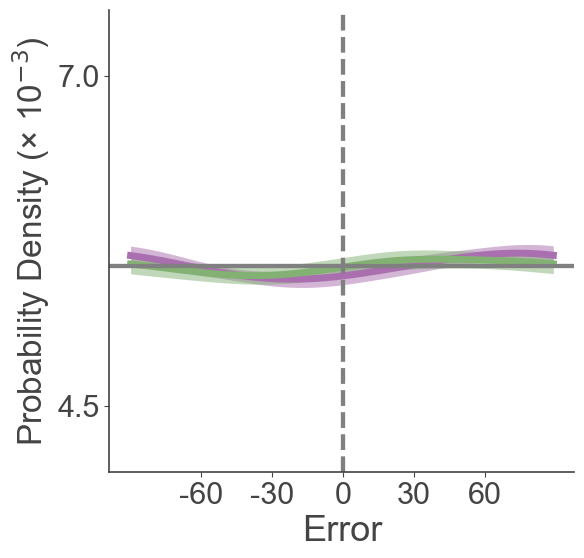

In [145]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_before_cue,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'enc1_before_cue_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [146]:
enc1_decode_results_during_cue = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_during_cue, enc1_phase_during_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat   p_val
stim 1  0.129  0.092  1.4021  0.1697
stim 2  0.075  0.108  0.6877  0.4962
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1 -0.028       0.061 -0.4619  0.6470
stim 2 -0.062       0.070 -0.8767  0.3866


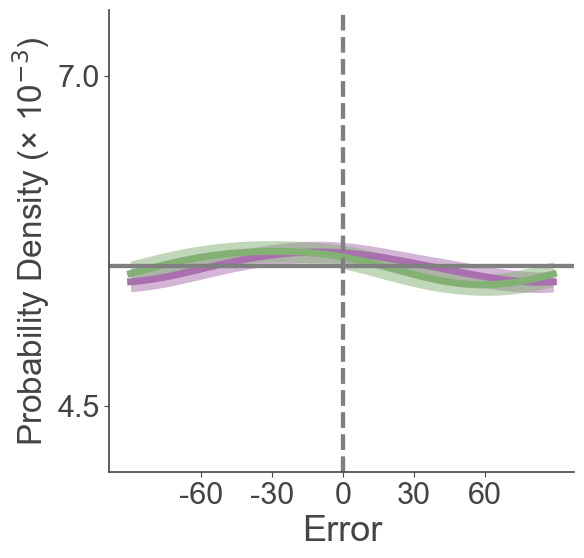

In [147]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_during_cue,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'enc1_during_cue_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [148]:
enc1_decode_results_after_cue = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_after_cue, enc1_phase_after_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat   p_val
stim 1  1.087  0.154  7.0352  0.0000
stim 2  0.053  0.065  0.8206  0.4175
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1  0.014       0.106  0.1276  0.8992
stim 2 -0.013       0.051 -0.2525  0.8021


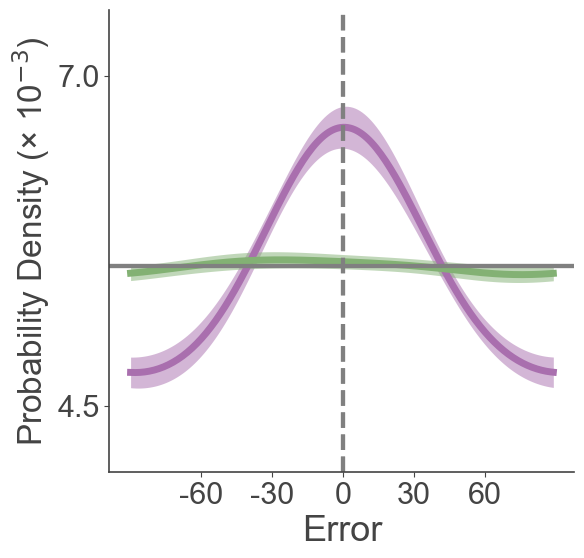

In [149]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_after_cue,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'enc1_after_cue_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [150]:
## isi
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = valid_isi_lmb
    if stats_type == 'sd':
        common_lmb = lambda d: valid_isi_lmb(d) & has_valid_prev_lmb(d)
    store_subject_stats(
        enc1_decode_results_before_cue, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'enc1_before_cue_combined',
        item_weights_lmb=isi_item_weights_lmb,
        sharpness=ISI_best_sharpness)
    
for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = valid_isi_lmb
    if stats_type == 'sd':
        common_lmb = lambda d: valid_isi_lmb(d) & has_valid_prev_lmb(d)
    store_subject_stats(
        enc1_decode_results_after_cue, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'enc1_after_cue_combined',
        item_weights_lmb=isi_item_weights_lmb,
        sharpness=ISI_best_sharpness)

Saving click accuracy stats
Saving click sd stats
Saving click sur stats
Saving click accuracy stats
Saving click sd stats
Saving click sur stats


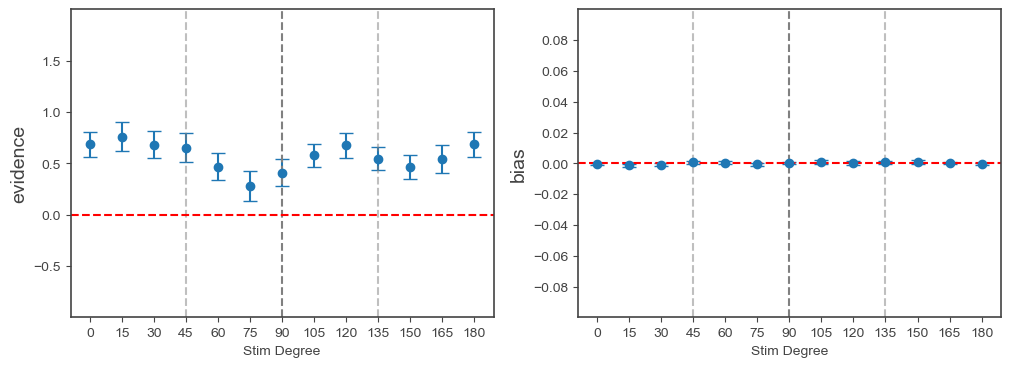

In [151]:
display_acc_bias_as_tuning(
    results=enc1_decode_results_after_cue,
    common_lmb=valid_isi_lmb, condition_name='enc',
    item_weights_lmb=isi_item_weights_lmb,
    to_fetch='stim 1',
    sharpness=ISI_best_sharpness)

##### Does Encoding Gaze pattern generalize to later phase?

In [152]:
enc1_isi_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_after_cue, ISI_phase,
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat   p_val
stim 1  0.788  0.137  5.7725  0.0000
stim 2 -0.010  0.076 -0.1256  0.9008
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1 -0.203       0.091 -2.2417  0.0314
stim 2  0.021       0.061  0.3416  0.7347


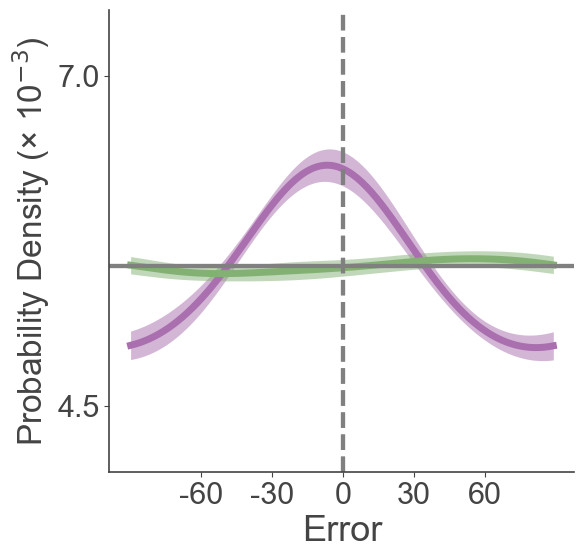

In [153]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_isi_decode_results,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)
plot_path = os.path.join(PLOTS_FOLDER, 'enc1_isi_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [154]:
enc1_delay_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_after_cue, delay_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, None,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
           mean    sem  t_stat  p_val
stim 1    0.856  0.111  7.6794    0.0
stim 2    0.603  0.100  6.0116    0.0
combined  0.760  0.087  8.7689    0.0
--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1   -0.178       0.078 -2.2698  0.0295
stim 2   -0.084       0.067 -1.2477  0.2204
combined -0.131       0.058 -2.2591  0.0302


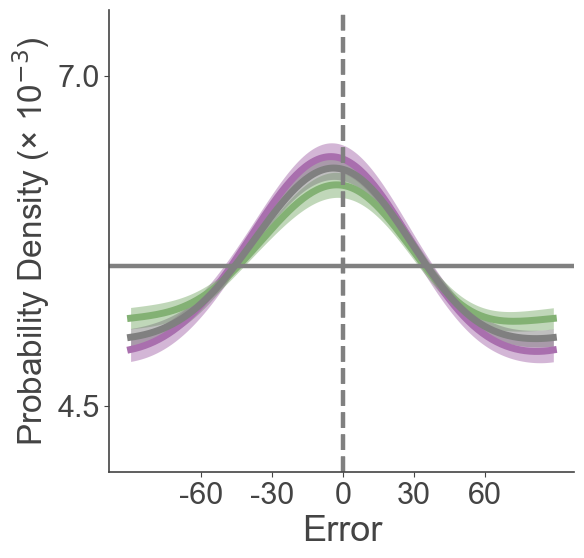

In [155]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

stats_results = display_stats_and_distrib(ax,
    enc1_delay_decode_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb, # assuming taking all?
    sharpness=delay_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'enc1_delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

##### For comparision: get the late encoding result of stim 2

In [156]:
enc2_phase_after_cue = np.arange(start=3750//50, stop=4000//50).astype(int)

In [157]:
enc2_decode_results = cv_train_test_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    enc2_phase_after_cue, enc2_phase_after_cue, 
    ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
    None, None,
    item_weights_lmb, n_subjects)

--- accuracy ---
           mean    sem  t_stat   p_val
stim 1    0.378  0.086  4.3686  0.0001
stim 2    0.502  0.113  4.4269  0.0001
combined  0.436  0.072  6.0201  0.0000
--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1   -0.048       0.078 -0.6147  0.5427
stim 2    0.094       0.090  1.0466  0.3025
combined  0.034       0.068  0.5061  0.6159


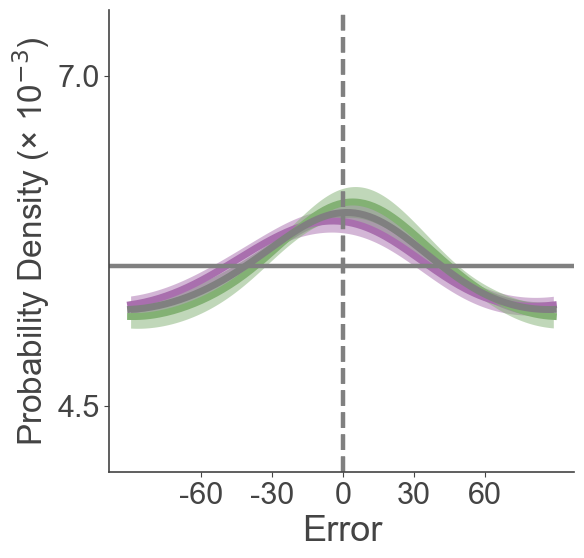

In [158]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    enc2_decode_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
# print(stats_results)
print_stats_results_as_tables(stats_results)
# ax.set_title('Errors: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'enc2_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')


##### store the results

In [159]:
# store enc1 -> isi
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = valid_isi_lmb
    if stats_type == 'sd':
        common_lmb = lambda d: valid_isi_lmb(d) & has_valid_prev_lmb(d)
    store_subject_stats(
        enc1_isi_decode_results, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'enc1_isi_combined',
        item_weights_lmb=isi_item_weights_lmb,
        sharpness=ISI_best_sharpness)
    

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


In [160]:
# store enc1 -> delay
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = None
    if stats_type == 'sd':
        common_lmb = has_valid_prev_lmb
    store_subject_stats(
        enc1_delay_decode_results, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'enc1_delay_combined',
        item_weights_lmb=item_weights_lmb,
        sharpness=delay_best_sharpness)

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


#### We also need to run within subject analysis for comparison

In [161]:
from utils.inverted_encoding import raw_within_subj_cross_phase_iterator

def within_subj_cross_phase_iterator(*args, **kwargs):
    return raw_within_subj_cross_phase_iterator(
        reformat_all_loaded,
        *args, **kwargs
    )

def cv_train_test_within_subject_invert_encoding(*args, **kwargs):
    return raw_cv_train_test_invert_encoding(
        within_subj_cross_phase_iterator,
        *args, **kwargs
    )
         

##### encoding

In [162]:
enc1_decode_results_after_cue_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_after_cue, enc1_phase_after_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, kfold=5)

In [163]:
enc1_decode_results_during_cue_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_during_cue, enc1_phase_during_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, kfold=5)

In [164]:
enc1_decode_results_before_cue_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_before_cue, enc1_phase_before_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, kfold=5)

--- accuracy ---
         mean    sem  t_stat   p_val
stim 1  0.695  0.201  3.4512  0.0015
stim 2  0.080  0.087  0.9221  0.3628
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1  0.038       0.060  0.6380  0.5277
stim 2  0.109       0.074  1.4683  0.1510


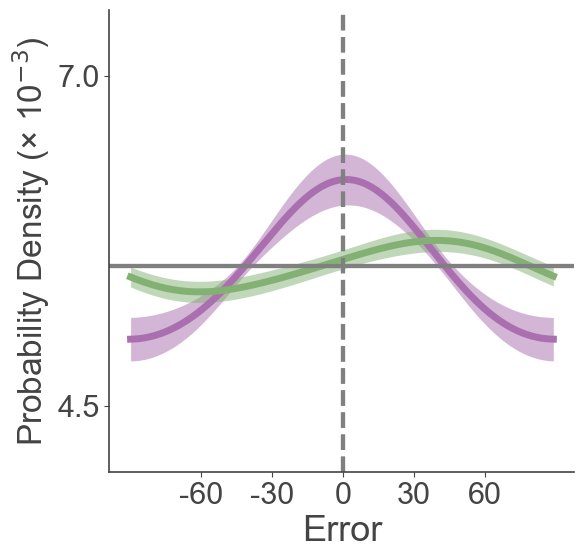

In [165]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_after_cue_within_subj,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_enc1_after_cue_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

--- accuracy ---
         mean    sem  t_stat   p_val
stim 1 -0.057  0.095 -0.5948  0.5558
stim 2  0.074  0.093  0.7969  0.4309
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1 -0.040       0.052 -0.7728  0.4448
stim 2 -0.003       0.060 -0.0554  0.9561


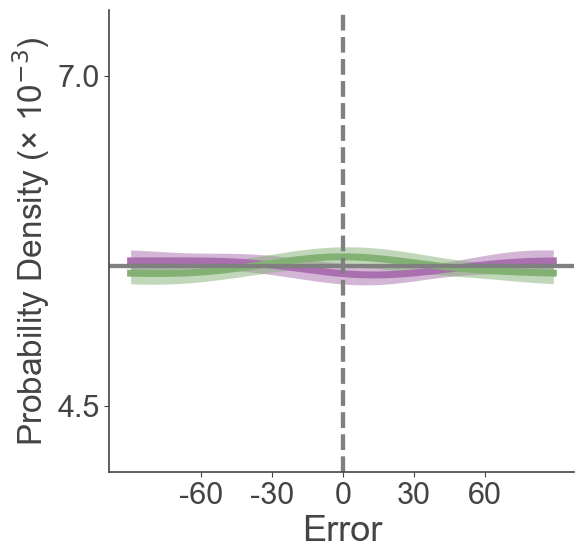

In [166]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_during_cue_within_subj,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_enc1_during_cue_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

--- accuracy ---
         mean    sem  t_stat   p_val
stim 1 -0.048  0.089 -0.5460  0.5885
stim 2 -0.016  0.086 -0.1856  0.8539
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1  0.087       0.048  1.8127  0.0785
stim 2  0.023       0.062  0.3682  0.7149


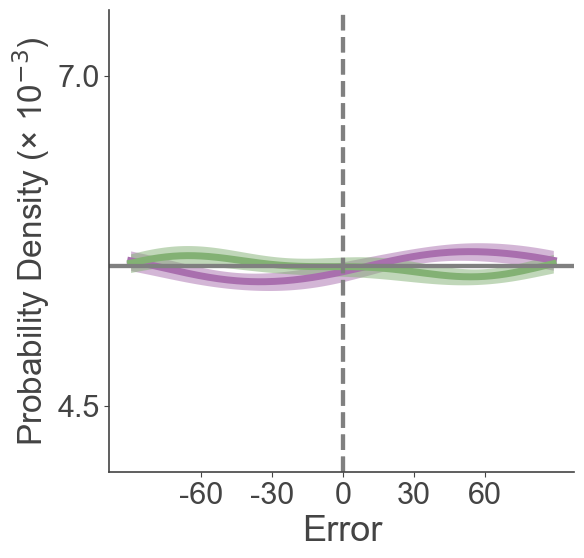

In [167]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_before_cue_within_subj,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_enc1_before_cue_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [168]:
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = valid_isi_lmb
    if stats_type == 'sd':
        common_lmb = lambda d: valid_isi_lmb(d) & has_valid_prev_lmb(d)
    store_subject_stats(
        enc1_decode_results_after_cue_within_subj, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'within_subj_enc1_after_cue_combined',
        item_weights_lmb=isi_item_weights_lmb,
        sharpness=ISI_best_sharpness)

Saving click accuracy stats


Saving click sd stats
Saving click sur stats


##### now do within-subject analysis during ISI

In [169]:
isi_decode_results_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    ISI_phase, ISI_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, kfold=5)

--- accuracy ---
         mean    sem  t_stat   p_val
stim 1  0.991  0.196  5.0557  0.0000
stim 2 -0.027  0.076 -0.3592  0.7216
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1  0.053       0.042  1.2746  0.2109
stim 2 -0.046       0.053 -0.8536  0.3992


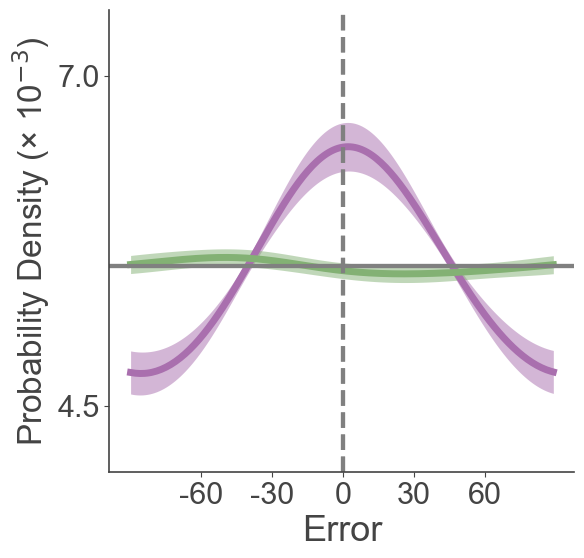

In [170]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    isi_decode_results_within_subj,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_isi_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [171]:
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'draw': {
        'target': 'stim 1',
        'lmb': draw_lmb,
    },
    'click': {
        'target': 'stim 1',
        'lmb': click_lmb,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = valid_isi_lmb
    if stats_type == 'sd':
        common_lmb = lambda d: valid_isi_lmb(d) & has_valid_prev_lmb(d)
    store_subject_stats(
        isi_decode_results_within_subj, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'within_subj_isi_combined',
        item_weights_lmb=isi_item_weights_lmb,
        sharpness=ISI_best_sharpness)

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


##### Now repeat if for delay

In [172]:
delay_decode_results_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    delay_phase, delay_phase, 
    ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
    None, None,
    item_weights_lmb, kfold=5)

--- accuracy ---
           mean    sem  t_stat   p_val
stim 1    0.776  0.124  6.2370  0.0000
stim 2    0.409  0.129  3.1606  0.0032
combined  0.655  0.120  5.4534  0.0000
--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1   -0.048       0.051 -0.9398  0.3538
stim 2    0.059       0.073  0.8138  0.4213
combined -0.005       0.045 -0.1088  0.9140


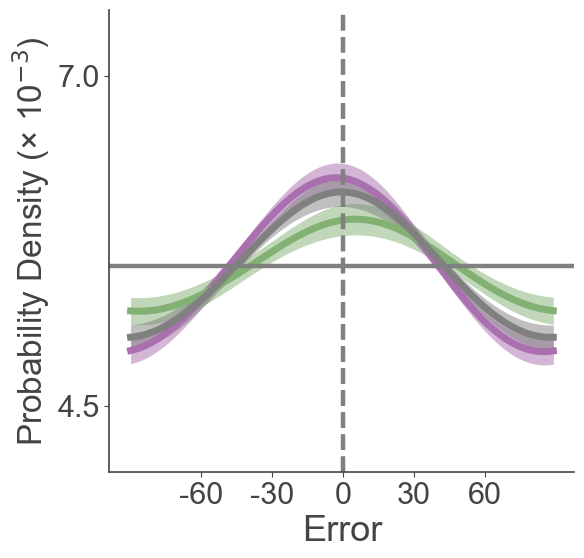

In [173]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    delay_decode_results_within_subj,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [174]:
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
    },
    'click': {
        'target': 'combined',
        'lmb': click_lmb,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = None
    if stats_type == 'sd':
        common_lmb = has_valid_prev_lmb
    store_subject_stats(
        delay_decode_results_within_subj, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'within_subj_delay_combined',
        item_weights_lmb=item_weights_lmb,
        sharpness=delay_best_sharpness)

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


##### Again, check whether encoding pattern generalize in within subject condition

In [175]:
enc1_isi_decode_results_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_after_cue, ISI_phase,
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, kfold=5)

--- accuracy ---
         mean    sem  t_stat  p_val
stim 1  0.740  0.134  5.5258  0.000
stim 2 -0.043  0.082 -0.5219  0.605
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1 -0.056       0.081 -0.6942  0.4921
stim 2  0.019       0.050  0.3849  0.7026


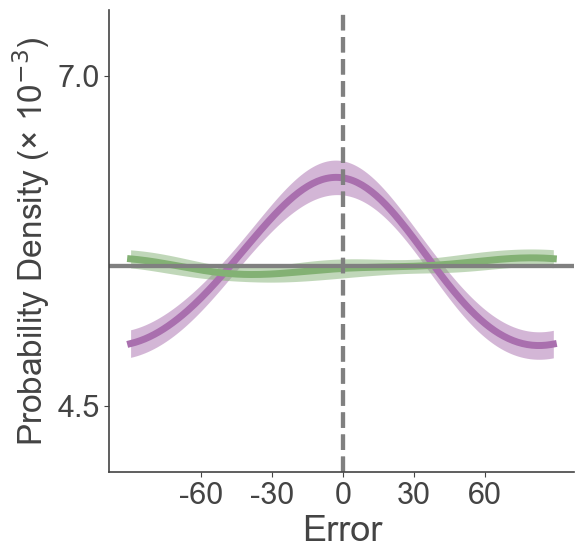

In [176]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_isi_decode_results_within_subj,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_enc1_isi_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [177]:
enc1_delay_decode_results_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_after_cue, delay_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, None,
    isi_item_weights_lmb, kfold=5)

--- accuracy ---
           mean    sem  t_stat   p_val
stim 1    0.360  0.117  3.0821  0.0040
stim 2    0.335  0.107  3.1425  0.0034
combined  0.338  0.098  3.4585  0.0014
--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1   -0.081       0.083 -0.9851  0.3313
stim 2   -0.032       0.061 -0.5246  0.6031
combined -0.044       0.045 -0.9736  0.3370


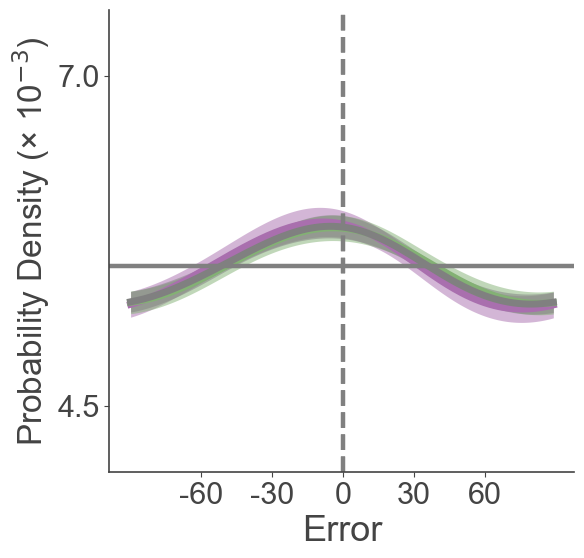

In [178]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

stats_results = display_stats_and_distrib(ax,
    enc1_delay_decode_results_within_subj,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb, # assuming taking all?
    sharpness=delay_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_enc1_delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [179]:
isi_delay_decode_results_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    ISI_phase, delay_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, None,
    isi_item_weights_lmb, kfold=5)

--- accuracy ---
           mean    sem  t_stat   p_val
stim 1    0.687  0.142  4.8361  0.0000
stim 2    0.533  0.136  3.9278  0.0004
combined  0.591  0.126  4.6769  0.0000
--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1    0.161       0.050  3.2136  0.0028
stim 2    0.066       0.064  1.0280  0.3110
combined  0.089       0.048  1.8645  0.0707


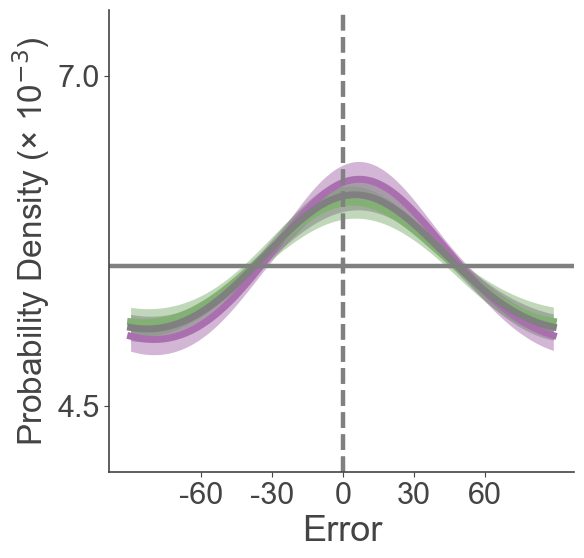

In [180]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

stats_results = display_stats_and_distrib(ax,
    isi_delay_decode_results_within_subj,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb, # assuming taking all?
    sharpness=delay_best_sharpness
)
print_stats_results_as_tables(stats_results)
plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_isi_delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

#### Comments
- clicking is easier to decode; drawing seems more complex
- the distribution of erros is not perfectly centered at 0
- No clear traces of serial bias
- The transformation from channel activation prediction to stimuli seems trivial but is actually crucial but I haven't figured out a perfect solution...


## Now further split the delay

In [181]:
from utils.inverted_encoding import raw_within_across_phase_train_test

def within_across_phase_train_test(phases, train_test_lmb, 
        all_phase_steps=[0, 1], train_weight_lmb=item_weights_lmb):
    return raw_within_across_phase_train_test(
        phases, train_test_lmb, 
        subjs=all_subjs,
        train_test_iterator=across_subj_cross_phase_iterator,
        model_params=DEFAULT_FORWARD_MODEL_PARAMS,
        item_weights_lmb=train_weight_lmb,
        all_phase_steps=all_phase_steps,
    )

### First check something simpler?

In [182]:
critical_stim1_phases = [enc1_phase_after_cue, ISI_phase,]
within_stim1_only_phase_results = within_across_phase_train_test(
    critical_stim1_phases, stim1_valid_lmb, 
    all_phase_steps=[0,],
    train_weight_lmb=isi_item_weights_lmb)[0]

within_delay_phase_results = within_across_phase_train_test(
    delay_phases, None, all_phase_steps=[0,],
    train_weight_lmb=item_weights_lmb)[0]

100%|██████████| 9/9 [00:34<00:00,  3.83s/it]


In [183]:
within_all_phase_results = within_stim1_only_phase_results + within_delay_phase_results

In [207]:
cond_map = {
    'wheel': 'click',
}

def extract_critical_phase_stats(test_results, stat_type, n_stim1_only=2, mode_separate_train=False):
    # first two phases -- stim1- remembered only
    # last two phases -- stim1 or stim 2

    common_lmb = None
    if stat_type == 'sd':
        common_lmb = has_valid_prev_lmb

    collected_stats = []
    stats_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': stim1_valid_lmb,
            'to_plot': False,
        },
    }
    
    for t, time_point_results in enumerate(test_results):
        if t < n_stim1_only:
            target_name = 'stim 1'
            selected_item_weights_lmb = isi_item_weights_lmb
        else:
            target_name = 'combined'
            stats_settings = {
                'stim 1': {
                    'target': 'stim 1',
                    'lmb': stim1_valid_lmb,
                    'to_plot': False,
                },
                'stim 2': {
                    'target': 'stim 2',
                    'lmb': stim2_valid_lmb,
                    'to_plot': False,
                },
                'combined': {
                    'target': 'combined',
                    'lmb': None,
                    'to_plot': False,
                },
            }
            selected_item_weights_lmb = item_weights_lmb

        timepoint_stats = {}
        if mode_separate_train:
            for mode in ['draw', 'wheel']:
                mode_stats_settings = stats_settings.copy()
                mode_lmb = draw_lmb if mode == 'draw' else click_lmb
                mode_stats_settings[mode] = {
                    'target': target_name,
                    'lmb': mode_lmb,
                    'to_plot': False,
                }
                _, mode_stats_results = display_stats_and_distrib(
                    None,
                    time_point_results[cond_map.get(mode, mode)],
                    stats_type=stat_type, 
                    common_lmb=common_lmb, 
                    condition_lmbs=mode_stats_settings,
                    item_weights_lmb=selected_item_weights_lmb,
                    return_subj_stats=True)
                timepoint_stats[mode] = mode_stats_results[mode]

        else:
            stats_settings['draw'] = {
                'target': target_name,
                'lmb': draw_lmb,
                'to_plot': False,
            }
            stats_settings['wheel'] = {
                'target': target_name,
                'lmb': click_lmb,
                'to_plot': False,
            }

            _, raw_timepoint_stats = display_stats_and_distrib(
                None,
                time_point_results,
                stats_type=stat_type, 
                common_lmb=common_lmb, 
                condition_lmbs=stats_settings,
                item_weights_lmb=selected_item_weights_lmb,
                return_subj_stats=True)

            # select only relevant
            timepoint_stats = {
                'combined': raw_timepoint_stats[target_name],
                'draw': raw_timepoint_stats['draw'],
                'wheel': raw_timepoint_stats['wheel'],
            }

        collected_stats.append(timepoint_stats)

    return collected_stats


In [185]:
critical_acc_stats = extract_critical_phase_stats(
    within_all_phase_results, stat_type='accuracy')

In [ ]:
from utils.inverted_encoding import plot_critical_phase_mode_difference

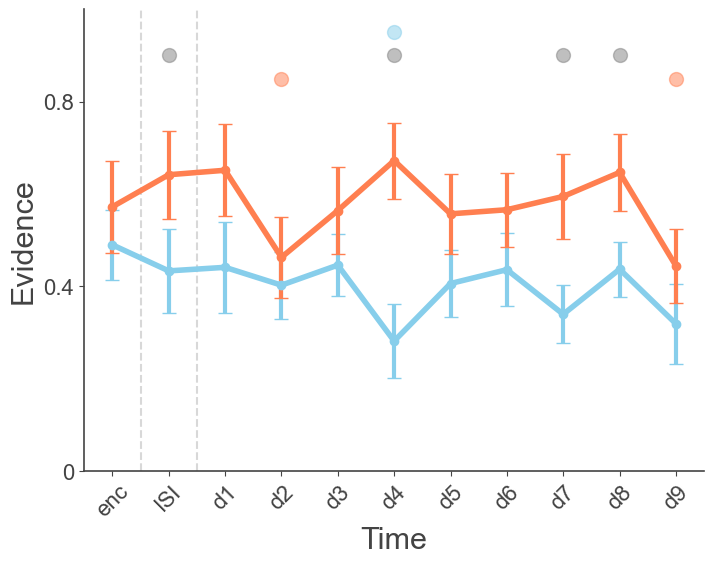

In [220]:
plot_critical_phase_mode_difference(
    time_stats=critical_acc_stats, stat_type='accuracy',
    mode_colors=MODE_COLOR_MAPPINGS, cond_color_map=cond_map,
    show_sig_change=True, sig_ref_first=False)

#### Now use one fixed phase for training, test on or subsequent phases

In [218]:
from utils.inverted_encoding import raw_ref_fixed_tested_all

def ref_fixed_tested_all(
        train_phase, test_phases, 
        train_stims, test_stims, 
        train_lmb, test_lmb, 
        train_weight_lmb,
        mode_separate_train):
    return raw_ref_fixed_tested_all(
        train_test_iterator=across_subj_cross_phase_iterator,
        model_params=DEFAULT_FORWARD_MODEL_PARAMS,
        train_phase=train_phase, test_phases=test_phases,
        train_stims=train_stims, test_stims=test_stims,
        train_lmb=train_lmb, test_lmb=test_lmb, 
        train_weight_lmb=train_weight_lmb,
        n_subjects=n_subjects,
        separate_mode=mode_separate_train
    )

all_critical_phase = critical_stim1_phases + delay_phases

def all_fixed_train_test_across_critical(stat_type, mode_separate_train=True):
    ref_ids = [0, 1, 2]
    ref_is_stim1_only = [True, True, False]

    # collect raw results
    for i, train_phase_id in enumerate(ref_ids):
        is_stim1_only = ref_is_stim1_only[i]
        train_stims = ['stim_1',] if is_stim1_only else ['stim_1', 'stim_2']
        train_lmb = stim1_valid_lmb if is_stim1_only else None
        train_weights = isi_item_weights_lmb if is_stim1_only else item_weights_lmb
        raw_iem_results = ref_fixed_tested_all(
            train_phase=all_critical_phase[train_phase_id], 
            test_phases=all_critical_phase[train_phase_id:], 
            train_stims=train_stims, 
            test_stims=['stim_1', 'stim_2'], 
            train_lmb=train_lmb, 
            test_lmb=None, 
            train_weight_lmb=train_weights,
            mode_separate_train=mode_separate_train
        )

        # collect stats
        n_stim1_only_test = int(np.sum(
            ref_is_stim1_only[i:]
        ))
        critical_stats = extract_critical_phase_stats(
            raw_iem_results, 
            stat_type=stat_type, 
            n_stim1_only=n_stim1_only_test,
            mode_separate_train=mode_separate_train
        )
        
        # plot it
        plot_critical_phase_mode_difference(
            time_stats=critical_stats, stat_type=stat_type,
            mode_colors=MODE_COLOR_MAPPINGS, cond_color_map=cond_map,
            n_stim1_only=n_stim1_only_test,
            show_sig_change=True,)


100%|██████████| 9/9 [00:43<00:00,  4.85s/it]


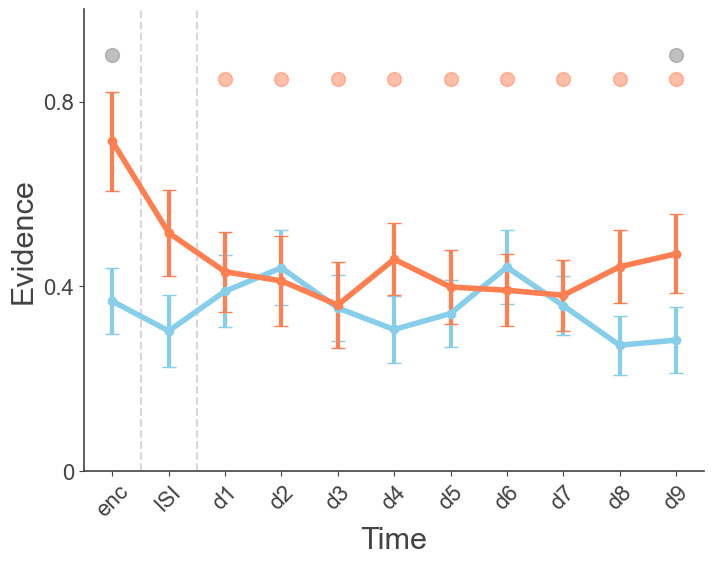

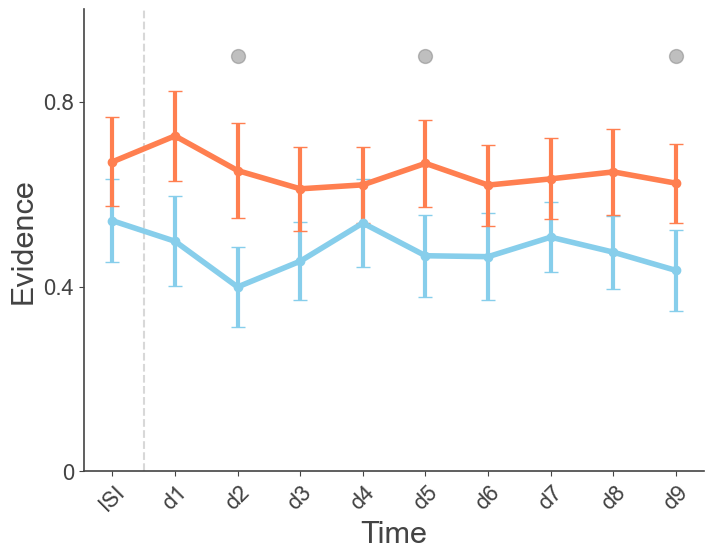

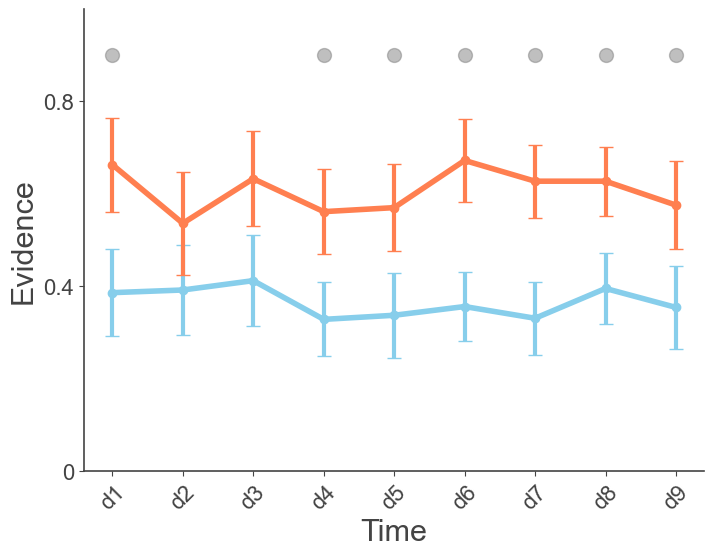

In [219]:
all_fixed_train_test_across_critical('accuracy', mode_separate_train=True)

### Then more complicated analysis

#### create sliding windows throughout the delay

In [ ]:
from utils.inverted_encoding import generate_windows

DELAY_WINDOWS = generate_windows(delay_phase, 20, 5)
N_DELAY_WINDOW = len(DELAY_WINDOWS)
print(f'{N_DELAY_WINDOW} windows, each of {len(DELAY_WINDOWS[0])} time points')

15 windows, each of 20 time points


#### Load subjects of general good decodability

In [ ]:
subj_delay_quality_path = os.path.join(
    PROCESSED_FOLDER, 'whole_delay_combined', 'accuracy.json')
with open(subj_delay_quality_path, 'r') as fp:
    subj_delay_quality = json.load(fp)

In [ ]:
good_acc_thresh = 0.4
good_delay_subjects = [int(subj) for subj, acc in subj_delay_quality['combined']['accuracy'].items() if acc > good_acc_thresh]

In [ ]:
len(good_delay_subjects)

25

In [ ]:
good_delay_subject_set = set(good_delay_subjects)
good_delay_subject_lmb = lambda d: d['participant'].isin(good_delay_subject_set).values

### distribution of errors

In [ ]:
from utils.inverted_encoding import (
    raw_plot_single_stats_over_phase,
    raw_plot_stats_over_phase
)

def plot_single_stats_over_phase(
        ax, pred_results, stats_type, stat_name, phase_step,
        plot_settings, common_lmb, 
        plot_ymin=None, plot_ymax=None, label=None,
        show_significance=False):

    return raw_plot_single_stats_over_phase(
        ax, pred_results, stats_type, stat_name, phase_step,
        plot_settings, common_lmb, 
        plot_ymin=plot_ymin, plot_ymax=plot_ymax, label=label,
        stats_computation_func=display_stats_and_distrib,
        item_weights_lmb=item_weights_lmb,
        show_significance=show_significance)

def plot_stats_over_phase(
        pred_results, stats_type, plot_settings, 
        common_lmb, plot_ymin=None, plot_ymax=None,
        show_single_significance=False,
        show_pairwise_significance=False):
    return raw_plot_stats_over_phase(
        pred_results, stats_type, plot_settings,
        common_lmb, plot_ymin=plot_ymin, plot_ymax=plot_ymax,
        stats_computation_func=display_stats_and_distrib,
        item_weights_lmb=item_weights_lmb,
        show_single_significance=show_single_significance,
        show_pairwise_significance=show_pairwise_significance,
    )

#### First check when memory load = 2

In [ ]:
mem2_cross_phase_results = within_across_phase_train_test(DELAY_WINDOWS, valid_both_lmb)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [01:54<00:00,  7.61s/it]


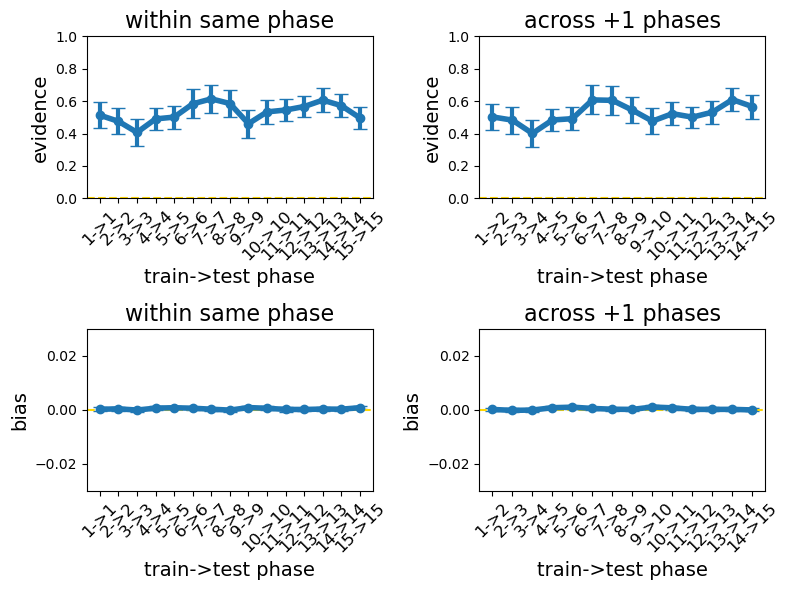

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem2_cross_phase_results, 'accuracy', 
    plot_settings, valid_both_lmb,
    show_single_significance=False)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_multi_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

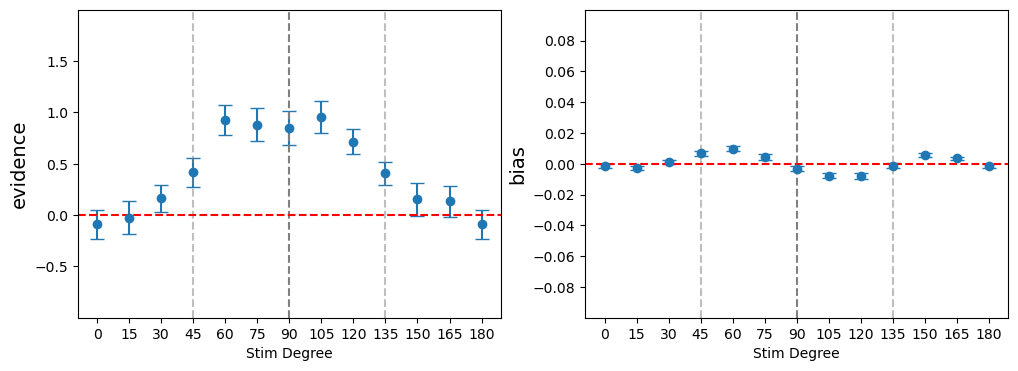

In [ ]:
display_acc_bias_as_tuning(
    results=mem2_cross_phase_results[0][-1],
    common_lmb=valid_both_lmb, condition_name='last_phase_delay')

#### TODO: compute all stats

#### for all, draw, and click

In [ ]:
for phase_id in [0, -1]:
    phase_name = 'first' if phase_id == 0 else 'last'
    print("phase: ", phase_name)
    test_lmb = valid_both_lmb
    stat_extract_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': stim1_valid_lmb,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': stim2_valid_lmb,
        },
        'combined': {
            'target': 'combined',
            'lmb': None,
        },
        'draw': {
            'target': 'combined',
            'lmb': draw_lmb,
        },
        'click': {
            'target': 'combined',
            'lmb': click_lmb,
        }
    }

    results = mem2_cross_phase_results[0][phase_id]
    for stats_type in ['accuracy', 'sd', 'sur']:
        print(f'Saving {stats_type} stats')
        common_lmb = test_lmb
        if stats_type == 'sd':
            common_lmb = has_valid_prev_lmb
        store_subject_stats(
            results, 
            common_lmb, 
            stat_extract_settings, 
            stats_type, 
            f'delay_{phase_name}_phase_combined',
            item_weights_lmb=item_weights_lmb,
            sharpness=delay_best_sharpness)
        

phase:  first
Saving accuracy stats
Saving sd stats
Saving sur stats
phase:  last
Saving accuracy stats
Saving sd stats
Saving sur stats


##### Comment:

Probably it is **NOT** possible to tease out surrounding bias...Anyway the decoding of the current target will be interfered by the non-target; but we can check how the bias change over time?

#### Further split the draw and click

##### Drawing

In [ ]:
draw_both_lmb = lambda df: (draw_lmb(df) & valid_both_lmb(df))

In [ ]:
draw_mem2_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, draw_both_lmb)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [01:17<00:00,  5.16s/it]


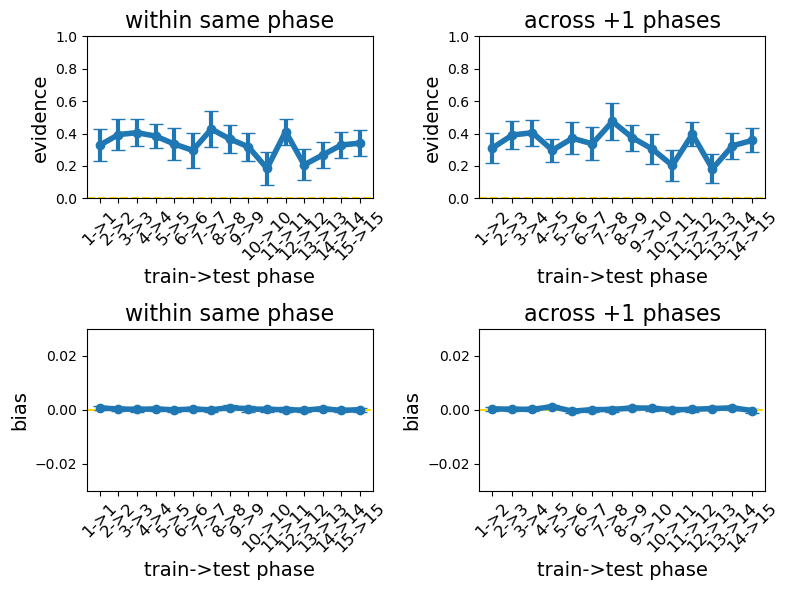

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    draw_mem2_cross_phase_results, 'accuracy', 
    plot_settings, draw_both_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'draw_delay_decoded_multi_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

##### are there oblique or cardinal bias the last phase ?

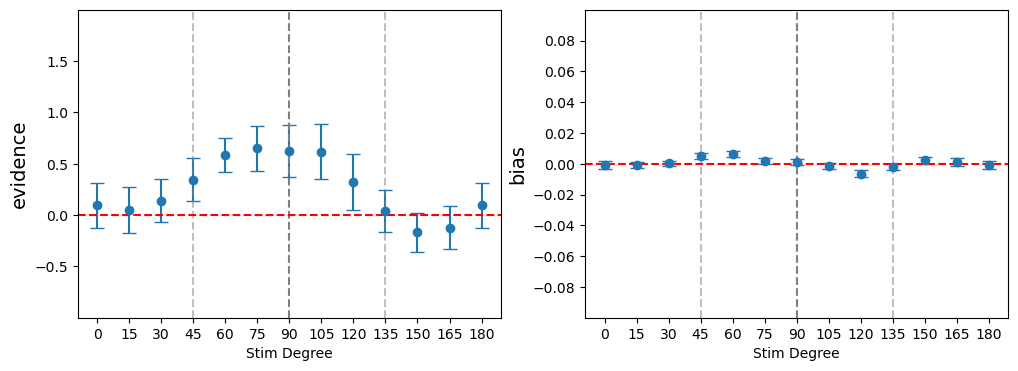

In [ ]:
display_acc_bias_as_tuning(
    results=draw_mem2_cross_phase_results[0][0],
    common_lmb=draw_both_lmb, condition_name='draw_first_phase_delay')

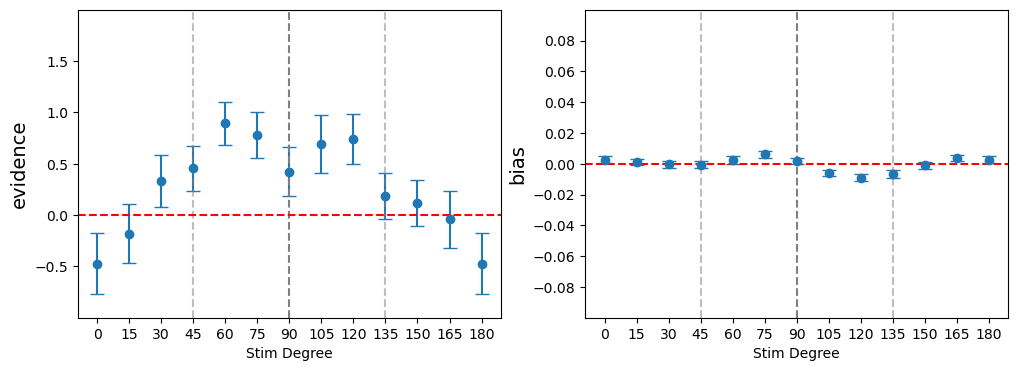

In [ ]:
display_acc_bias_as_tuning(
    results=draw_mem2_cross_phase_results[0][-1],
    common_lmb=draw_both_lmb, condition_name='draw_last_phase_delay')

##### Clicking

In [ ]:
click_both_lmb = lambda df: (click_lmb(df) & valid_both_lmb(df))

In [ ]:
click_mem2_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, click_both_lmb)

100%|██████████| 15/15 [01:16<00:00,  5.11s/it]


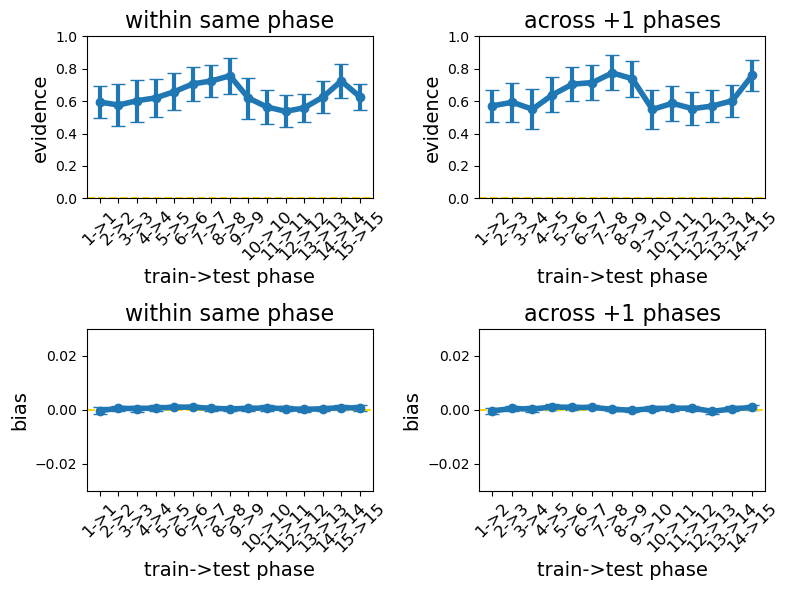

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    click_mem2_cross_phase_results, 'accuracy', 
    plot_settings, click_both_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'click_delay_decoded_multi_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

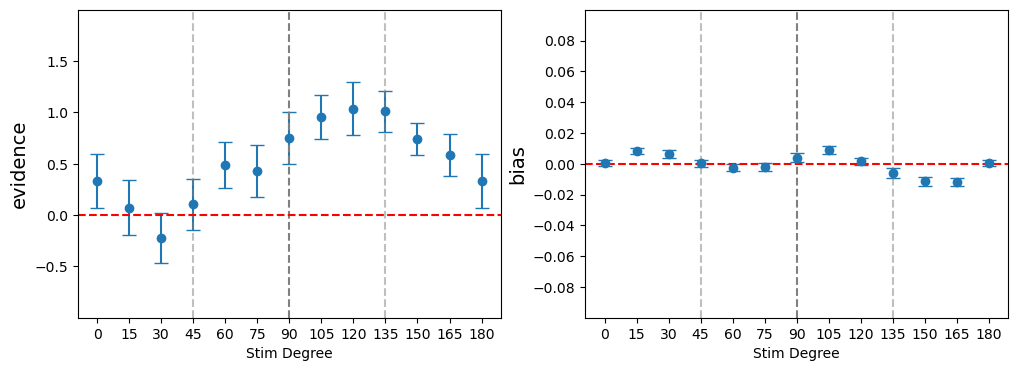

In [ ]:
display_acc_bias_as_tuning(
    results=click_mem2_cross_phase_results[0][0],
    common_lmb=click_both_lmb, condition_name='click_first_phase_delay')

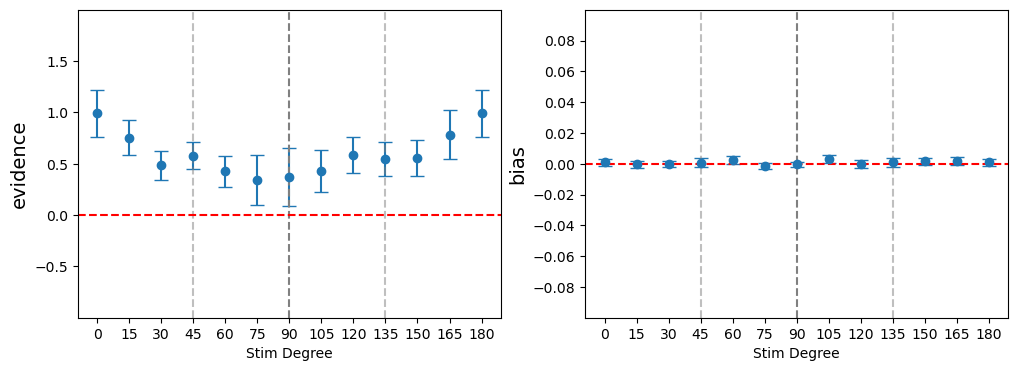

In [ ]:
display_acc_bias_as_tuning(
    results=click_mem2_cross_phase_results[0][-1],
    common_lmb=click_both_lmb, condition_name='click_last_phase_delay')

##### Also store the stats at the first and last phase of delay

In [ ]:
mode_cross_phase_results = {
    'draw': draw_mem2_cross_phase_results,
    'click': click_mem2_cross_phase_results,
}

for phase_id in [0, -1]:
    phase_name = 'first' if phase_id == 0 else 'last'
    for mode in ['draw', 'click']:
        test_lmb = mode_lmbs[mode]
        stat_extract_settings = {
            'stim 1': {
                'target': 'stim 1',
                'lmb': stim1_valid_lmb,
            },
            'stim 2': {
                'target': 'stim 2',
                'lmb': stim2_valid_lmb,
            },
            'combined': {
                'target': 'combined',
                'lmb': None,
            },
        }

        results = mode_cross_phase_results[mode][0][phase_id]

        for stats_type in ['accuracy', 'sd', 'sur']:
            print(f'Saving {mode} {stats_type} stats')
            common_lmb = test_lmb
            if stats_type == 'sd':
                common_lmb = mode_prev_lmbs[mode]
            store_subject_stats(
                results, 
                common_lmb, 
                stat_extract_settings, 
                stats_type, 
                f'delay_{phase_name}_phase_{mode}2{mode}',
                item_weights_lmb=item_weights_lmb,
                sharpness=delay_best_sharpness)
        

Saving draw accuracy stats
Saving draw sd stats
Saving draw sur stats
Saving click accuracy stats
Saving click sd stats
Saving click sur stats
Saving draw accuracy stats
Saving draw sd stats
Saving draw sur stats
Saving click accuracy stats
Saving click sd stats
Saving click sur stats


In [ ]:
for phase_id in [0, -1]:
    phase_name = 'first' if phase_id == 0 else 'last'
    test_lmb = valid_both_lmb
    stat_extract_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': stim1_valid_lmb,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': stim2_valid_lmb,
        },
        'combined': {
            'target': 'combined',
            'lmb': None,
        },
    }

    results = mem2_cross_phase_results[0][phase_id]
    for stats_type in ['accuracy', 'sd', 'sur']:
        print(f'Saving {mode} {stats_type} stats')
        common_lmb = test_lmb
        if stats_type == 'sd':
            common_lmb = mode_prev_lmbs[mode]
        store_subject_stats(
            results, 
            common_lmb, 
            stat_extract_settings, 
            stats_type, 
            f'delay_{phase_name}_phase_combined',
            item_weights_lmb=item_weights_lmb,
            sharpness=delay_best_sharpness)
        

Saving click accuracy stats
Saving click sd stats
Saving click sur stats
Saving click accuracy stats
Saving click sd stats
Saving click sur stats


#### When does draw and click start diverging?

In [ ]:
from tqdm import tqdm

def within_phase_cross_mode_train_test(phases, train_lmb, test_lmb):
    all_phase_steps = [0,]
    n_train_phases = len(phases)
    phases_results = [[] for _ in all_phase_steps]

    n_subjects = len(all_subjs)
    for train_id in tqdm(range(n_train_phases)):
        for phase_step in all_phase_steps:
            test_id = train_id + phase_step
            if test_id >= len(phases):
                continue
            # get results
            train_phase = phases[train_id]
            test_phase = phases[test_id]
            results = cv_train_test_invert_encoding(
                DEFAULT_FORWARD_MODEL_PARAMS, 
                train_phase, test_phase, 
                ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
                train_lmb, test_lmb, 
                item_weights_lmb, n_subjects, use_tqdm=False)
            phases_results[phase_step].append(results)

    return phases_results

In [ ]:
within_phase_draw2click_results = within_phase_cross_mode_train_test(
    DELAY_WINDOWS, draw_both_lmb, click_both_lmb)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


In [ ]:
within_phase_click2draw_results = within_phase_cross_mode_train_test(
    DELAY_WINDOWS, click_both_lmb, draw_both_lmb)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:39<00:00,  2.61s/it]


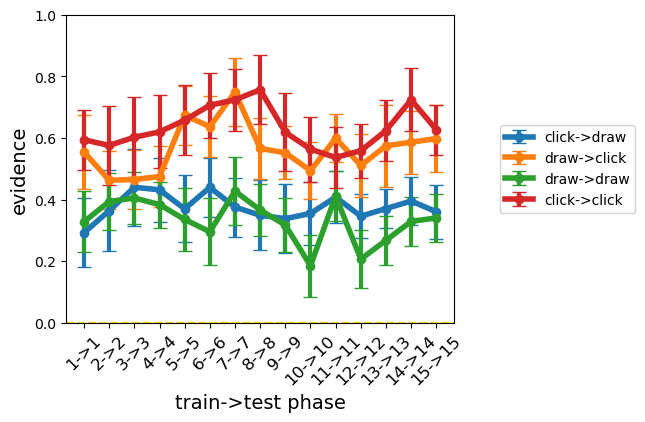

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

fig, ax = plt.subplots(1, figsize=(5, 4))
plot_single_stats_over_phase(
    ax, within_phase_click2draw_results[0], 
    'accuracy', 'accuracy', 0,
    plot_settings, draw_both_lmb, 
    plot_ymin=None, plot_ymax=None, label='click->draw')
plot_single_stats_over_phase(
    ax, within_phase_draw2click_results[0], 
    'accuracy', 'accuracy', 0,
    plot_settings, click_both_lmb, 
    plot_ymin=None, plot_ymax=None, label='draw->click')

# for comparision, plot the within mode results
plot_single_stats_over_phase(
    ax, draw_mem2_cross_phase_results[0],
    'accuracy', 'accuracy', 0,
    plot_settings, draw_both_lmb,
    plot_ymin=None, plot_ymax=None, label='draw->draw')
plot_single_stats_over_phase(
    ax, click_mem2_cross_phase_results[0],
    'accuracy', 'accuracy', 0,
    plot_settings, click_both_lmb,
    plot_ymin=None, plot_ymax=None, label='click->click')

plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left')
plot_path = os.path.join(PLOTS_FOLDER, 'cross_mode_delay_decoded_multi_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')


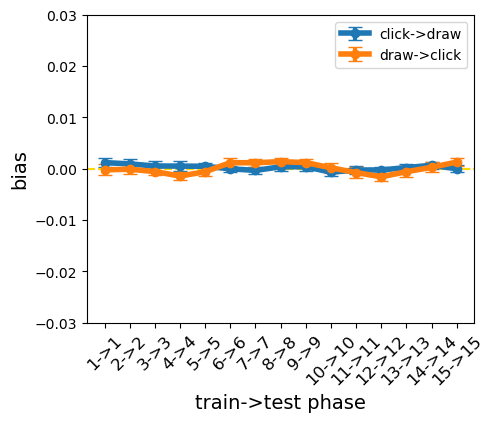

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

fig, ax = plt.subplots(1, figsize=(5, 4))
plot_single_stats_over_phase(
    ax, within_phase_click2draw_results[0], 
    'accuracy', 'bias', 0,
    plot_settings, draw_both_lmb, 
    plot_ymin=None, plot_ymax=None, label='click->draw')
plot_single_stats_over_phase(
    ax, within_phase_draw2click_results[0], 
    'accuracy', 'bias', 0,
    plot_settings, click_both_lmb, 
    plot_ymin=None, plot_ymax=None, label='draw->click')

plt.legend(bbox_to_anchor=(1, 1), loc='upper right')
plot_path = os.path.join(PLOTS_FOLDER, 'cross_mode_delay_decoded_multi_phases_acc_bias_stats.png')
plt.savefig(plot_path, bbox_inches='tight')


##### Hypothesis: the gaze patterns 'evolve' over time, but differently for different modes

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

# phase 1-> 6, 6 -> 11, 1 -> 11
def show_over_delay_decoding_divergence(common_lmb):
    start_id = 0
    end_id = len(DELAY_WINDOWS) - 1
    mid1_id = int(np.round(len(DELAY_WINDOWS) / 3)) - 1
    mid2_id = int(np.round(len(DELAY_WINDOWS) * 2 / 3)) - 1

    phase_ids = [start_id, mid1_id, mid2_id, end_id]
    collected_results = {
        'phase_ids': phase_ids,
    }
    for stat_name in ['accuracy', 'bias']:
        for stype in ['mean', 'sem']:
            collected_results[f'{stat_name}_{stype}'] = np.zeros((len(phase_ids), len(phase_ids)))
            collected_results[f'{stat_name}_{stype}'].fill(np.nan)

    for train_id, test_id in zip(
            [0, 1, 2, 0, 1, 0],
            [1, 2, 3, 2, 3, 3]):
        train_phase = DELAY_WINDOWS[phase_ids[train_id]]
        test_phase = DELAY_WINDOWS[phase_ids[test_id]]
        results = cv_train_test_invert_encoding(
            DEFAULT_FORWARD_MODEL_PARAMS, 
            train_phase, test_phase, 
            ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
            common_lmb, common_lmb, 
            item_weights_lmb, n_subjects, use_tqdm=False)
        
        # compute accuracy
        stats = display_stats_and_distrib(
            None, results,
            stats_type='accuracy', 
            common_lmb=common_lmb, condition_lmbs=plot_settings,
            item_weights_lmb=item_weights_lmb)
        stats = stats['combined']
        print(f'==={train_id} -> {test_id}===')

        # formulate data
        for stat_name in ['accuracy', 'bias']:
            for stype in ['mean', 'sem']:
                collected_results[f'{stat_name}_{stype}'][train_id, test_id] = stats[stat_name][stype]

        print(f'accuracy: {stats["accuracy"]["mean"]:.3f} +/- {stats["accuracy"]["sem"]:.3f}')
        print(f'bias: {stats["bias"]["mean"]:.3f} +/- {stats["bias"]["sem"]:.3f}')

    return collected_results

def plot_cross_phase_evolve(ax, results, stat_name):
    phase_ids = results['phase_ids']
    mean_name = f'{stat_name}_mean'
    sem_name = f'{stat_name}_sem'
    mean_table = results[mean_name]
    sem_table = results[sem_name]

    color_level_maps = [
        'blue', 'green', 'red',]

    n_phases = len(mean_table) 
    for i in range(n_phases):
        for j in range(i+1, n_phases):
            if np.isnan(mean_table[i, j]):
                continue
            color = color_level_maps[j-i-1]
            ax.fill_between(
                [i, j], 
                mean_table[i, j] - sem_table[i, j], 
                mean_table[i, j] + sem_table[i, j], 
                alpha=0.2, color=color, linewidth=0)
            ax.plot(
                [i, j], [mean_table[i, j], mean_table[i, j]], 
                marker='o',
                color=color, linewidth=2)
            
    for i, phase_id in enumerate(phase_ids):
        ax.axvline(i, color='gray', linestyle='--', alpha=0.3)
    
    ax.set_xticks(np.arange(n_phases))
    ax.set_xticklabels(phase_ids)
    ax.set_xlabel('phases', fontsize=16)
    ylabel_name = 'generalizability' if stat_name == 'accuracy' else 'shift'
    ax.set_ylabel(ylabel_name, fontsize=16)


In [ ]:
draw_cross_phase_evolve = show_over_delay_decoding_divergence(draw_both_lmb)

===0 -> 1===
accuracy: 0.342 +/- 0.084
bias: 0.000 +/- 0.001
===1 -> 2===
accuracy: 0.516 +/- 0.100
bias: 0.001 +/- 0.001
===2 -> 3===
accuracy: 0.214 +/- 0.081
bias: 0.001 +/- 0.001
===0 -> 2===
accuracy: 0.387 +/- 0.085
bias: -0.000 +/- 0.001
===1 -> 3===
accuracy: 0.373 +/- 0.107
bias: 0.001 +/- 0.001
===0 -> 3===
accuracy: 0.380 +/- 0.085
bias: 0.000 +/- 0.001


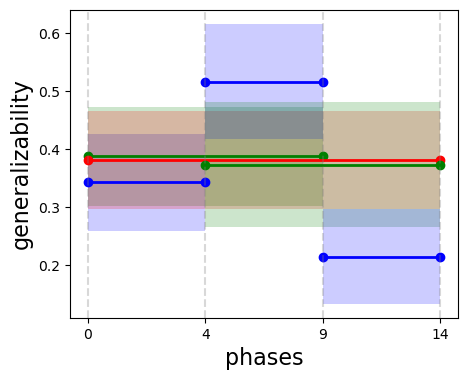

In [ ]:
fig, ax = plt.subplots(1, figsize=(5, 4))
plot_cross_phase_evolve(ax, draw_cross_phase_evolve, 'accuracy')
plot_path = os.path.join(PLOTS_FOLDER, 'draw_cross_phase_evolve.png')
plt.savefig(plot_path, bbox_inches='tight')

In [ ]:
click_cross_phase_evolve = show_over_delay_decoding_divergence(click_both_lmb)

===0 -> 1===
accuracy: 0.618 +/- 0.089
bias: 0.000 +/- 0.001
===1 -> 2===
accuracy: 0.684 +/- 0.119
bias: 0.001 +/- 0.001
===2 -> 3===
accuracy: 0.658 +/- 0.095
bias: 0.000 +/- 0.001
===0 -> 2===
accuracy: 0.592 +/- 0.099
bias: -0.001 +/- 0.001
===1 -> 3===
accuracy: 0.531 +/- 0.102
bias: 0.001 +/- 0.001
===0 -> 3===
accuracy: 0.680 +/- 0.103
bias: -0.000 +/- 0.001


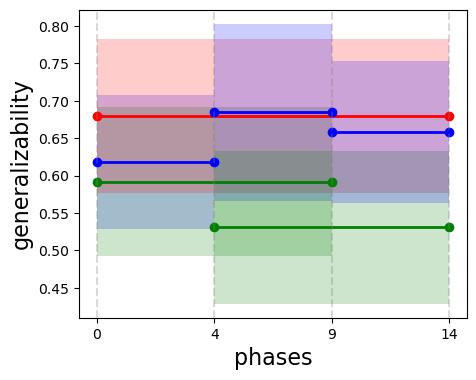

In [ ]:
fig, ax = plt.subplots(1, figsize=(5, 4))
plot_cross_phase_evolve(ax, click_cross_phase_evolve, 'accuracy')
plot_path = os.path.join(PLOTS_FOLDER, 'click_cross_phase_evolve.png')
plt.savefig(plot_path, bbox_inches='tight')

**comment**: ok hard to tell. But it seems for drawing there is a big shift in representation especially during the middle phase; in comparision, representation of clicking is more stable. This correspond to the self-reported strategy (from the prelimary study)

#### Lastly, switch to memory load is 1

In [ ]:
mem1_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, valid_single_item_lmb)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [01:07<00:00,  4.47s/it]


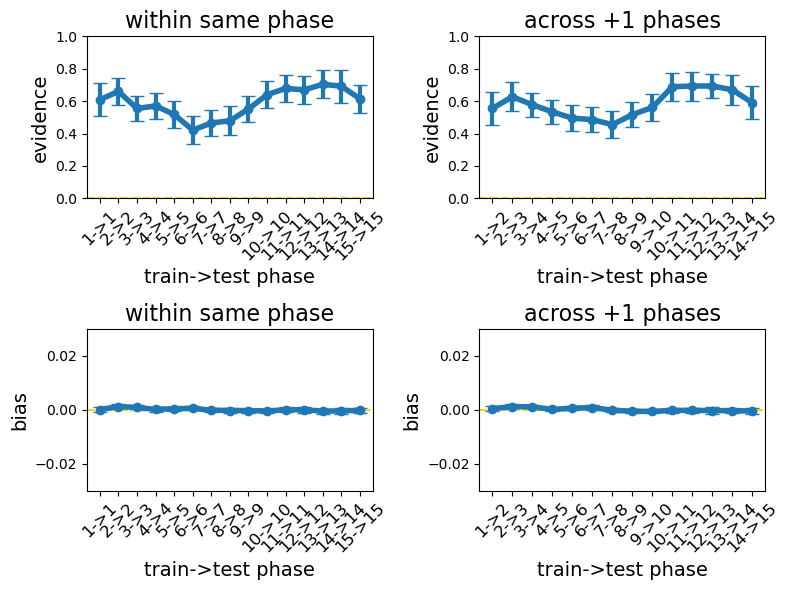

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem1_cross_phase_results, 'accuracy', 
    plot_settings, valid_single_item_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_single_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

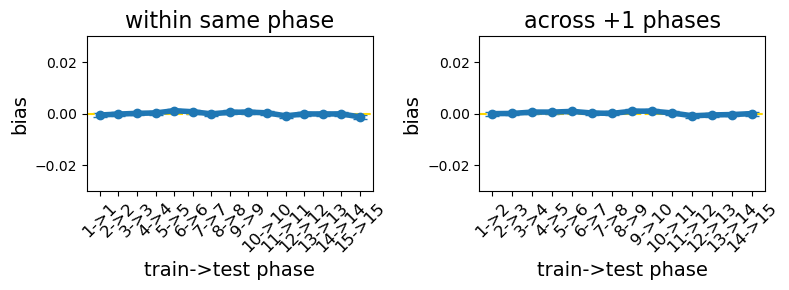

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem1_cross_phase_results, 'sd', 
    plot_settings, single_has_prev_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_single_phases_sd_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

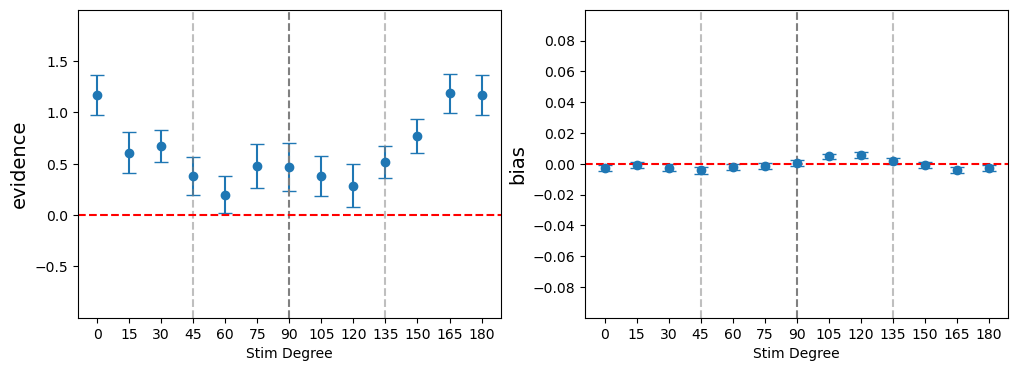

In [ ]:
display_acc_bias_as_tuning(
    results=mem1_cross_phase_results[0][-1],
    common_lmb=valid_single_item_lmb, condition_name='last_phase_single_delay')

##### Comment
But we can directly plot SURROUNDING bias for load=1. There is no significant bias though. Also there is no significant serial bias. All aligns with the behavior results.

#### Also store the decoded...

In [ ]:
def compute_and_store_decoded_distrib(all_results, result_name, sharpness=delay_best_sharpness, lmb=None):
    all_result_path = os.path.join(PROCESSED_FOLDER, 'predictions', f'{result_name}')
    os.makedirs(all_result_path, exist_ok=True)

    # store data apply to the whole phase
    y_df_path = os.path.join(all_result_path, 'y_df.csv')
    ys_path = os.path.join(all_result_path, 'ys.npy')

    for tid, results in enumerate(all_results):
        # process the result at time t
        result_path = os.path.join(all_result_path, f'phase_{tid}')
        os.makedirs(result_path, exist_ok=True)

        y_pred_distrib = channel_weights_to_pseudo_distrib(
            results['preds'], delay_model, sharpness=sharpness)
        y_df = results['test_df'].reset_index(drop=True)
        ys = results['test_ys']

        # note that df have been shuffled so we need to correct the order...
        trial_orders = y_df['TRIALID'].argsort()
        y_df = y_df.iloc[trial_orders].reset_index(drop=True)
        ys = ys[trial_orders]
        y_pred_distrib = y_pred_distrib[trial_orders]

        # lmb fitting
        if lmb is not None:
            y_mask = lmb(y_df)
            y_df = y_df[y_mask]
            ys = ys[y_mask]
            y_pred_distrib = y_pred_distrib[y_mask]

        # store the settings
        if tid == 0:
            y_df.to_csv(y_df_path, index=False)
            np.save(ys_path, ys)

        # store the raw predicted distribution
        y_pred_distrib_path = os.path.join(result_path, 'y_pred_distrib.npy')
        np.save(y_pred_distrib_path, y_pred_distrib)

        # store the aligned version
        aligned_path = os.path.join(result_path, 'aligned')
        os.makedirs(aligned_path, exist_ok=True)
        stim_names = ['stim_1', 'stim_2']
        for sid, stim_name in enumerate(stim_names):
            # specify the references to compare with
            stim_path = os.path.join(aligned_path, f'{stim_name}')
            os.makedirs(stim_path, exist_ok=True)
            ref_types = {
                'target': '',
                'nontarget': f'stim_{2-sid}',
                'previous': 'prev_last_response',
            }
            for ref_type in ref_types:
                ref_align_path = os.path.join(stim_path, f'{ref_type}.npy')
                ref_name = ref_types[ref_type]
                refs = None
                if ref_name:
                    refs = y_df[ref_name].to_numpy(copy=True)

                # save the aligned distribution and mask
                y_distrib, y_valid_mask = shift_align_distrib(
                    y_pred_distrib, ys[:, sid], refs=refs)
                y_distrib[~y_valid_mask] = np.nan
                np.save(ref_align_path, y_distrib)

##### store the results from train-test separately

In [ ]:
compute_and_store_decoded_distrib(
    all_results=draw_mem2_cross_phase_results[0],
    result_name='draw_delay_phase',
    sharpness=delay_best_sharpness)

In [ ]:
compute_and_store_decoded_distrib(
    all_results=click_mem2_cross_phase_results[0],
    result_name='click_delay_phase',
    sharpness=delay_best_sharpness)

##### store the results from joint-training testing

In [ ]:
compute_and_store_decoded_distrib(
    all_results=mem2_cross_phase_results[0],
    result_name='mixed_draw_delay_phase',
    sharpness=delay_best_sharpness,
    lmb=draw_lmb)

In [ ]:
compute_and_store_decoded_distrib(
    all_results=mem2_cross_phase_results[0],
    result_name='mixed_click_delay_phase',
    sharpness=delay_best_sharpness,
    lmb=click_lmb)